# Installs, Imports, Drive Connection, WandB Connection

##### Installs

In [ ]:
!pip install transformers
!pip install datasets
!pip install -U PyYAML
!pip install "ray[default]"
!pip install wandb
!pip install tensorboardX

     |████████████████████████████████| 2.5 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 61.3 MB/s 
     |████████████████████████████████| 895 kB 90.9 MB/s 
     |████████████████████████████████| 262 kB 4.3 MB/s 
     |████████████████████████████████| 243 kB 25.2 MB/s 
     |████████████████████████████████| 118 kB 36.3 MB/s 
     |████████████████████████████████| 636 kB 4.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 51.6 MB 67 kB/s 
     |████████████████████████████████| 72 kB 683 kB/s 
     |████████████████████████████████| 1.3 MB 66.5 MB/s 
     |████████████████████████████████| 65 kB 4.9 MB/s 
     |████████████████████████████████| 3.1 MB 93.1 MB/s 
     |████████████████████████████████| 10.1 MB 79.1 MB/s 
     |████████████████████████████████| 78 kB 9.2 MB/s 
     |████████████████████████████████| 127 kB 8

##### Imports

In [ ]:
import sys
import os
import shutil
import numpy as np
import pandas as pd
import yaml
from transformers import pipeline
import wandb
from datasets import concatenate_datasets, load_dataset
import torch
from pathlib import Path
import pickle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from scipy.special import softmax
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import math

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

##### Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### WandB Connection

In [ ]:
# saves our models to artifacts in WandB
import wandb
%env WANDB_LOG_MODEL=true
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_LOG_MODEL=true
env: WANDB_PROJECT=goodreads_success_predictor


In [ ]:
wandb.login(key = '46cb1981ae15765be5bfb5e7c3257d0315a95a1b')

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Dataset Generator

### Load Text Data

#### goodreads_maharjan

In [ ]:
dataset = load_dataset('/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/raw_preprocessed/trimmed_and_nered/goodreadsnered.py')

Dataset good_reads_practice_dataset downloaded and prepared to /root/.cache/huggingface/datasets/good_reads_practice_dataset/main_domain/1.1.0/4b7b7cdb5b45d1b6276e312eee9d568222cf98e5769c2e0add2dfb13d3694756. Subsequent calls will reuse this data.


#### goodreads_guarro

In [ ]:
goodreads_guarro = True
dataset = load_dataset('/content/drive/MyDrive/Thesis/Datasets/project_gutenberg/goodreads_guarro_loading_script.py')

### Custom Tokenization Process

#### From Scratch

##### Select Tokenizer

###### ALBERT

In [ ]:
!pip install sentencepiece
from transformers import AlbertTokenizerFast
tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2', additional_special_tokens = ['[CHARACTER]'])

     |████████████████████████████████| 1.2MB 6.9MB/s 


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


###### BERT

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', additional_special_tokens = ['[CHARACTER]'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


###### ROBERTA

In [ ]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', additional_special_tokens = ['[CHARACTER]'])

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


###### BigBird

In [ ]:
!pip install sentencepiece
from transformers import BigBirdTokenizer
tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base', additional_special_tokens = ['[CHARACTER]'])

     |████████████████████████████████| 1.2MB 5.3MB/s 


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


###### DistilBERT

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', additional_special_tokens = ['[CHARACTER]'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


###### ELECTRA

In [ ]:
from transformers import ElectraTokenizerFast
tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-small-discriminator', additional_special_tokens = ['[CHARACTER]'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


###### Longformer

In [ ]:
from transformers import LongformerTokenizer
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

###### XLNET

In [ ]:
!pip install sentencepiece
from transformers import XLNetTokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

     |████████████████████████████████| 1.2MB 14.9MB/s 


###### Do actual tokenizing and uploading

In [ ]:
# -*- coding: utf-8 -*-
import re
alphabets= "([A-Za-z])"
digits = "([0-9])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
prefixes = "(Mr|St|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|Mt)[.]" 
websites = "[.](com|net|org|io|gov|me|edu)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

import sys
def tokenize_book_and_make_labels(book, cut_off, success, tokenizer, chunk_limit = sys.maxsize, use_spacy = False):
  dictOfTokenizedChunks = split_book_into_nice_chunks(book, cut_off, tokenizer, chunk_limit, use_spacy)
  labels = [int(success)] * len(dictOfTokenizedChunks['input_ids'])
  return dictOfTokenizedChunks, labels

def seal_off_chunk(dictOfTokenizedChunks, currListOfInputIDs, cut_off):
  currListOfInputIDs.extend([102])
  attend_up_to = len(currListOfInputIDs)
  currListOfInputIDs.extend([0] * (cut_off - attend_up_to))
  
  dictOfTokenizedChunks['input_ids'].append(currListOfInputIDs)
  dictOfTokenizedChunks['token_type_ids'].append([0] * cut_off)
  dictOfTokenizedChunks['attention_mask'].append([1] * attend_up_to + [0] * (cut_off - attend_up_to))

# by default, we do not set a limit on the number of chunks.
def tokenize_complete_sentences(example, tokenizer, cut_off = 512, chunk_limit = sys.maxsize):
  if goodreads_guarro:
    dictOfTokenizedChunks = {'input_ids': [], 'token_type_ids': [], 'attention_mask': []}
  else:
    dictOfTokenizedChunks = {'input_ids': [], 'token_type_ids': [], 'attention_mask': [], 'success_label': None, 'genre': None, 'book_title': None}
    
  currListOfInputIDs = [101]
  split_book = split_into_sentences(example['text'])
  num_chunks = 0;
  needs_final_seal = False
  for sent in split_book:
    next_tokenized_sent = tokenizer(sent, add_special_tokens = False)['input_ids']
    if (len(currListOfInputIDs) + len(next_tokenized_sent) < cut_off - 1):
      currListOfInputIDs.extend(next_tokenized_sent)
      needs_final_seal = True
    else:
      seal_off_chunk(dictOfTokenizedChunks, currListOfInputIDs, cut_off)
      num_chunks += 1
      if num_chunks == chunk_limit:
        return dictOfTokenizedChunks
      currListOfInputIDs = [101]  
      needs_final_seal = False
  if (needs_final_seal):
    seal_off_chunk(dictOfTokenizedChunks, currListOfInputIDs, cut_off)

  if not goodreads_guarro:
    dictOfTokenizedChunks['success_label'] = [example['success_label']] * len(dictOfTokenizedChunks['input_ids'])
    dictOfTokenizedChunks['genre'] = [example['genre']] * len(dictOfTokenizedChunks['input_ids'])
    dictOfTokenizedChunks['book_title'] = [example['book_title']] * len(dictOfTokenizedChunks['input_ids'])
    # print(len(dictOfTokenizedChunks['input_ids']))
  return dictOfTokenizedChunks

In [ ]:
def tokenize_w_overlap(example, tokenizer):
  data_tokenize = tokenizer(example['text'], 
                  max_length = 512,
                  stride=50,
                  add_special_tokens=True,
                  return_attention_mask=True,
                  return_token_type_ids=True,
                  return_overflowing_tokens = True)
  num_chunks = len(data_tokenize['input_ids'])
  return {
      'input_ids': data_tokenize['input_ids'][:num_chunks-1], 
      'token_type_ids': data_tokenize['token_type_ids'][:num_chunks-1], 
      'attention_mask': data_tokenize['attention_mask'][:num_chunks-1], 
      'success_label': [example['success_label']] * (num_chunks-1), 
      'genre': [example['genre']] * (num_chunks-1), 
      'book_title': [example['book_title']] * (num_chunks-1)
  }

In [ ]:
# When batched = True, we take in multiple examples
def chunk_and_encode_examples_w_complete_sentences(examples):
  mega_dict = None
  if goodreads_guarro:
    mega_dict = {'attention_mask': [], 'input_ids': [], 'token_type_ids': []}
  else:
    mega_dict = {'attention_mask': [], 'genre': [], 'input_ids': [], 'success_label': [], 'token_type_ids': [], 'book_title': []}
  for i in range(len(examples['text'])):
    book_sample = None
    if goodreads_guarro:
      book_sample = {'text': examples['text'][i]}
    else:
      book_sample = {'text': examples['text'][i], 'genre': examples['genre'][i], 'success_label': examples['success_label'][i], 'book_title':examples['book_title'][i]}
    dictOfTokenizedChunks = tokenize_complete_sentences(book_sample, tokenizer)
    for key, value in dictOfTokenizedChunks.items():
      mega_dict[key].extend(value)
  return mega_dict

# When batched = True, we take in multiple examples
def chunk_and_encode_examples_w_overlap(examples):
  mega_dict = {'attention_mask': [], 'genre': [], 'input_ids': [], 'success_label': [], 'token_type_ids': [], 'book_title': []}
  for i in range(len(examples['text'])):
    book_sample = {'text': examples['text'][i], 'genre': examples['genre'][i], 'success_label': examples['success_label'][i], 'book_title':examples['book_title'][i]}
    dictOfTokenizedChunks = tokenize_w_overlap(book_sample, tokenizer)
    for key, value in dictOfTokenizedChunks.items():
      mega_dict[key].extend(value)
  return mega_dict

In [ ]:
chunked_encoded_dataset = dataset.map(chunk_and_encode_examples_w_overlap, remove_columns=dataset.column_names['train'], batched = True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 15752
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 11023
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 10816
    })
})

In [ ]:
chunked_encoded_dataset['train'].num_rows//2

7876

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

with open('train_dataset1.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['train'][0:chunked_encoded_dataset['train'].num_rows//2], output_file)

with open('train_dataset2.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['train'][chunked_encoded_dataset['train'].num_rows//2:chunked_encoded_dataset['train'].num_rows], output_file)

with open('val_dataset1.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['validation'][0:chunked_encoded_dataset['validation'].num_rows//2], output_file)

with open('val_dataset2.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['validation'][chunked_encoded_dataset['validation'].num_rows//2:chunked_encoded_dataset['validation'].num_rows], output_file)

with open('test_dataset1.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['test'][0:chunked_encoded_dataset['test'].num_rows//2], output_file)

with open('test_dataset2.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['test'][chunked_encoded_dataset['test'].num_rows//2:chunked_encoded_dataset['test'].num_rows], output_file)

folder_id = '1zJ_o7A-MEnEncUdVtCSfeRaP9PMMkqAq'
# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('train_dataset1.pkl')
file.Upload() 

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('train_dataset2.pkl')
file.Upload() 

# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('val_dataset1.pkl')
file.Upload() 

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('val_dataset2.pkl')
file.Upload() 

# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('test_dataset1.pkl')
file.Upload() 

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('test_dataset2.pkl')
file.Upload() 

##### Loading

In [ ]:
# def get_chunk_encoded_dataset(model_name, segment_size):

###### ALBERT_NER_512

In [ ]:
from datasets import DatasetDict
# (       r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/DistilBERT_UNCASED_NER_512/train_dataset.pkl", "rb")
with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/ALBERT_NER_512/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/ALBERT_NER_512/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/ALBERT_NER_512/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset

FileNotFoundError: ignored

###### DistilBERT_UNCASED_NER_512

W overlap. Since each data split exceeds the allowed upload limit per file to drive from google colab, it was split into 2. Thus we need to download the parts and combine them together.

In [ ]:
from datasets import DatasetDict, Dataset
from datasets import concatenate_datasets

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512_w50overlap_multitask/train_dataset1.pkl", "rb") as input_file:
  train_dataset1 = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512_w50overlap_multitask/train_dataset2.pkl", "rb") as input_file:
  train_dataset2 = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512_w50overlap_multitask/val_dataset1.pkl", "rb") as input_file:
  val_dataset1 = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512_w50overlap_multitask/val_dataset2.pkl", "rb") as input_file:
  val_dataset2 = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512_w50overlap_multitask/test_dataset1.pkl", "rb") as input_file:
  test_dataset1 = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512_w50overlap_multitask/test_dataset2.pkl", "rb") as input_file:
  test_dataset2 = pickle.load(input_file)

td1 = Dataset.from_dict(train_dataset1)
td2 = Dataset.from_dict(train_dataset2)

vd1 = Dataset.from_dict(val_dataset1)
vd2 = Dataset.from_dict(val_dataset2)

ted1 = Dataset.from_dict(test_dataset1)
ted2 = Dataset.from_dict(test_dataset2)

train_dataset = concatenate_datasets([td1, td2])
val_dataset = concatenate_datasets([vd1, vd2])
test_dataset = concatenate_datasets([ted1, ted2])

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})

w sentence-tokenizer

In [ ]:
from datasets import DatasetDict

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 14074
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 9872
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 9712
    })
})

###### ELECTRA 256

In [ ]:
from datasets import DatasetDict

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/ELECTRA_NER_256/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/ELECTRA_NER_256/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/ELECTRA_NER_256/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 27106
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 19036
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 18719
    })
})

###### ELECTRA 512

In [ ]:
from datasets import DatasetDict

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/ELECTRA_NER_512/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/ELECTRA_NER_512/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/ELECTRA_NER_512/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 14074
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 9872
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 9712
    })
})

###### BERT 512

Uncased

In [ ]:
from datasets import DatasetDict

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 14074
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 9872
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 9712
    })
})

Cased

In [ ]:
from datasets import DatasetDict

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_CASED_NER_512/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_CASED_NER_512/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_CASED_NER_512/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 14525
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 10151
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 10002
    })
})

###### ROBERTA 512

In [ ]:
from datasets import DatasetDict

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/ROBERTA_NER_512/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/ROBERTA_NER_512/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/ROBERTA_NER_512/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 14579
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 10171
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 9991
    })
})

###### BIGBIRD 2048

In [ ]:
from datasets import DatasetDict

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BIGBIRD_2048/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BIGBIRD_2048/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BIGBIRD_2048/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'token_type_ids'],
        num_rows: 3697
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'token_type_ids'],
        num_rows: 2590
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'token_type_ids'],
        num_rows: 2547
    })
})

###### BIGBIRD 4096

In [ ]:
from datasets import DatasetDict

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BIGBIRD_4096/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BIGBIRD_4096/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BIGBIRD_4096/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 1955
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 1368
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 1350
    })
})

#Dataset Exploration

In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 14074
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 9872
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 9712
    })
})

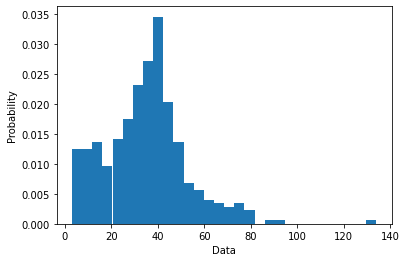

In [ ]:
num_segments_per_book = [len(list(g[1])) for g in itertools.groupby(chunked_encoded_dataset['train']['book_title'])]
import matplotlib.pyplot as plt

plt.hist(num_segments_per_book, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
import itertools
# [(g[0], len(list(g[1]))) for g in itertools.groupby(chunked_encoded_dataset['train']['book_title'])]
start_of_segmented_book = {}
last_idx = 0
for g in itertools.groupby(chunked_encoded_dataset['train']['book_title']):
  start_of_segmented_book[g[0]] = last_idx
  last_idx = len(list(g[1])) + last_idx

In [ ]:
start_of_segmented_book

{'10002_the+house+on+the+borderland.txt': 10969,
 "1006_divine+comedy+cary's+translation+purgatory.txt": 8310,
 '10083_the+house+of+the+whispering+pines.txt': 12906,
 '1020_sword+blades+and+poppy+seed.txt': 6111,
 '10671_the+botanic+garden.txt': 9771,
 '1069_four+short+stories+by+emile+zola.txt': 391,
 '1074_the+sea+wolf.txt': 13453,
 '1093_the+beast+in+the+jungle.txt': 5285,
 '1096_the+faith+of+men.txt': 2218,
 "1097_mrs+warren's+profession.txt": 10188,
 '1144_in+the+cage.txt': 1945,
 '1151_the+nibelungenlied.txt': 9470,
 '11656_the+great+shadow+and+other+napoleonic+tales.txt': 10655,
 '12116_struwwelpeter+merry+stories+and+funny+pictures.txt': 8761,
 '1218_the+adventures+of+jimmie+dale.txt': 9606,
 '12241_poems+by+emily+dickinson+third+series.txt': 1754,
 '12242_poems+by+emily+dickinson+three+series.txt': 10152,
 '1238_the+city+of+dreadful+night.txt': 8978,
 '1240_the+playboy+of+the+western+world.txt': 12638,
 '12509_the+moon+rock.txt': 7687,
 '1261_betty+zane.txt': 2260,
 '1279_poem

In [ ]:
# When batched = True, we take in multiple examples
def filter_segments(example, idx):
  if (idx - start_of_segmented_book[example['book_title']] < 40):
    return True
  else:
    return False

test = chunked_encoded_dataset['train'].filter(filter_segments, with_indices = True)

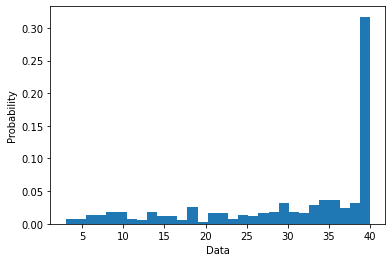

In [ ]:
num_segments_per_book = [len(list(g[1])) for g in itertools.groupby(test['book_title'])]

plt.hist(num_segments_per_book, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
chunked_encoded_dataset['train'] = chunked_encoded_dataset['train'].filter(filter_segments, with_indices = True)

# Pre Training

## BERT 512

In [ ]:
# Name our project from WandB
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_PROJECT=goodreads_success_predictor


In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.remove_columns(['book_title', 'genre', 'success_label'])

In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'token_type_ids'],
        num_rows: 14074
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'token_type_ids'],
        num_rows: 9872
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'token_type_ids'],
        num_rows: 9712
    })
})

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', additional_special_tokens = ['[CHARACTER]'])

from transformers import AutoModelForMaskedLM
model = AutoModelForMaskedLM.from_pretrained('bert-base-cased')
model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(28997, 768)

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)
from transformers import Trainer, TrainingArguments

num_epoch = 5

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

training_args = TrainingArguments(
    "bert-mlm",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    report_to = "wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=chunked_encoded_dataset['train'],
    eval_dataset=chunked_encoded_dataset['validation']
)

trainer.train()

wandb.finish()

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,2.822000,2.406996,209.843500,48.374000
2,2.315700,1.998168,209.853600,48.372000
3,2.169900,1.955170,209.779000,48.389000


train/loss,2.1699
train/learning_rate,0.0
train/epoch,3.0
train/global_step,5448
_runtime,4256
_timestamp,1620231928
_step,13
eval/loss,1.95517
eval/runtime,209.779
eval/samples_per_second,48.389
train/train_runtime,4256.4681


train/loss,█▆▆▄▃▃▂▁▁▁
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/epoch,▁▂▂▃▃▄▅▅▅▆▇▇██
train/global_step,▁▂▂▃▃▄▅▅▅▆▇▇██
_runtime,▁▂▂▃▃▄▄▅▅▆▇▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▇▇██
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█
eval/loss,█▂▁
eval/runtime,▇█▁
eval/samples_per_second,▂▁█
train/train_runtime,▁


## DistilBert 512

In [ ]:
# Name our project from WandB
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_PROJECT=goodreads_success_predictor


In [ ]:
%env WANDB_LOG_MODEL=true

env: WANDB_LOG_MODEL=true


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased', additional_special_tokens = ['[CHARACTER]'])

from transformers import AutoModelForMaskedLM
model = AutoModelForMaskedLM.from_pretrained('distilbert-base-uncased')
model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Embedding(30523, 768)

In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'token_type_ids'],
        num_rows: 386820
    })
})

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)
from transformers import Trainer, TrainingArguments

num_epoch = 1

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

training_args = TrainingArguments(
    "distilbert-mlm-guarro_goodreads",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size = 16,
    num_train_epochs = 1,
    # per_device_eval_batch_size=32,
    weight_decay=0.01,
    report_to = "wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=chunked_encoded_dataset['train']
)

trainer.train()

wandb.finish()

The following columns in the training set  don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: token_type_ids.
***** Running training *****
  Num examples = 386820
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 24177
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


Epoch,Training Loss,Validation Loss


Saving model checkpoint to distilbert-mlm-guarro_goodreads/checkpoint-500
Configuration saved in distilbert-mlm-guarro_goodreads/checkpoint-500/config.json
Model weights saved in distilbert-mlm-guarro_goodreads/checkpoint-500/pytorch_model.bin
Saving model checkpoint to distilbert-mlm-guarro_goodreads/checkpoint-1000
Configuration saved in distilbert-mlm-guarro_goodreads/checkpoint-1000/config.json
Model weights saved in distilbert-mlm-guarro_goodreads/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to distilbert-mlm-guarro_goodreads/checkpoint-1500
Configuration saved in distilbert-mlm-guarro_goodreads/checkpoint-1500/config.json
Model weights saved in distilbert-mlm-guarro_goodreads/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to distilbert-mlm-guarro_goodreads/checkpoint-2000
Configuration saved in distilbert-mlm-guarro_goodreads/checkpoint-2000/config.json
Model weights saved in distilbert-mlm-guarro_goodreads/checkpoint-2000/pytorch_model.bin
Saving model ch

## ROBERTA 512

In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.remove_columns(['book_title', 'genre', 'success_label'])

In [ ]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', additional_special_tokens = ['[CHARACTER]'])

from transformers import AutoModelForMaskedLM
model = AutoModelForMaskedLM.from_pretrained('roberta-base')
model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Embedding(50266, 768)

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)
from transformers import Trainer, TrainingArguments

num_epoch = 5

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

training_args = TrainingArguments(
    "roberta-mlm",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    num_train_epochs = 5,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    report_to = "wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=chunked_encoded_dataset['train'],
    eval_dataset=chunked_encoded_dataset['validation']
)

trainer.train()

wandb.finish()

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,1.939800,1.737092,238.022700,42.731000
2,1.858600,1.690681,237.600900,42.807000
3,1.827700,1.659989,237.420900,42.840000
4,1.772800,1.647067,237.410500,42.841000
5,1.755300,1.646039,237.429100,42.838000


train/loss,1.7553
train/learning_rate,0.0
train/epoch,5.0
train/global_step,9115
_runtime,7951
_timestamp,1620353649
_step,23
eval/loss,1.64604
eval/runtime,237.4291
eval/samples_per_second,42.838
train/train_runtime,7950.1742


train/loss,█▅▅▄▄▄▃▃▂▃▂▂▂▁▁▁▁▁
train/learning_rate,██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
train/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▇▇▇▇███
train/global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▇▇▇████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
eval/loss,█▄▂▁▁
eval/runtime,█▃▁▁▁
eval/samples_per_second,▁▆███
train/train_runtime,▁


## BIGBIRD 2048

In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.remove_columns(['book_title', 'genre', 'success_label'])

ValueError: ignored

In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'token_type_ids'],
        num_rows: 3697
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'token_type_ids'],
        num_rows: 2590
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'token_type_ids'],
        num_rows: 2547
    })
})

In [ ]:
from transformers import BigBirdTokenizer
tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base', additional_special_tokens = ['[CHARACTER]'])

from transformers import AutoModelForMaskedLM
model = AutoModelForMaskedLM.from_pretrained('google/bigbird-roberta-base')
model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.
Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(50359, 768)

In [ ]:
from transformers import AutoModelForMaskedLM
model = AutoModelForMaskedLM.from_pretrained('google/bigbird-roberta-base')
model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(50359, 768)

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)
from transformers import Trainer, TrainingArguments


data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

training_args = TrainingArguments(
    "bigbird-mlm",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    report_to = "wandb",
    gradient_accumulation_steps = 4
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=chunked_encoded_dataset['train'],
    eval_dataset=chunked_encoded_dataset['validation']
)
# gradient_accumulation_steps 
trainer.train()

wandb.finish()

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
0,2.539500,1.980498,1312.773900,1.973000
1,2.140800,1.918812,1367.968400,1.893000
2,2.071500,1.892684,1342.998400,1.929000


train/loss,2.0715
train/learning_rate,0.0
train/epoch,3.0
train/global_step,2772
_runtime,13055
_timestamp,1620279957
_step,8
eval/loss,1.89268
eval/runtime,1342.9984
eval/samples_per_second,1.929
train/train_runtime,13054.975


train/loss,█▃▂▂▁
train/learning_rate,█▆▅▃▁
train/epoch,▁▂▃▄▅▆▇██
train/global_step,▁▂▃▄▅▆▇██
_runtime,▁▃▃▄▅▆▇██
_timestamp,▁▃▃▄▅▆▇██
_step,▁▂▃▄▅▅▆▇█
eval/loss,█▃▁
eval/runtime,▁█▅
eval/samples_per_second,█▁▄
train/train_runtime,▁


In [ ]:
wandb.finish()

## ELECTRA 512

https://towardsdatascience.com/understanding-electra-and-training-an-electra-language-model-3d33e3a9660d

In [ ]:
# Name our project fro WandB
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_PROJECT=goodreads_success_predictor


In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.remove_columns(['book_title', 'genre', 'success_label'])

# GoodReads Success Prediction

### Functions used by all

#### For Prediction

In [ ]:
import matplotlib

class ModelScorer:
  def __init__(self, trainer, segmented_dataset, for_multitask = False):
    # self.segmented_dataset = segmented_dataset
    print("Getting predictions on validation set")
    val_dataset = segmented_dataset['validation']
    self.devset_predictions = trainer.predict(segmented_dataset['validation']).predictions
    self.val_book_changes_idx = self.get_book_changes_idx(val_dataset['book_title'])
    self.y_val_true = val_dataset['labels']

    print("Getting predictions on test set")
    test_dataset = segmented_dataset['test']
    self.testset_predictions = trainer.predict(segmented_dataset['test']).predictions
    self.test_book_changes_idx = self.get_book_changes_idx(test_dataset['book_title'])
    self.y_test_true = test_dataset['labels']

    if for_multitask:
      self.devset_predictions = self.devset_predictions[:,0:2]
      self.y_val_true = [item[0] for item in self.y_val_true]
      self.testset_predictions = self.testset_predictions[:,0:2]
      self.y_test_true = [item[0] for item in self.y_test_true]

#   def __init__(self, devset_predictions, testset_predictions, segmented_dataset, for_multitask = False):
#     self.devset_predictions = devset_predictions
#     self.testset_predictions = testset_predictions
    
#     val_dataset = segmented_dataset['validation']
#     self.val_book_changes_idx = self.get_book_changes_idx(val_dataset['book_title'])
#     self.y_val_true = val_dataset['labels']
#     # self.y_val_true = list( val_dataset['labels'][i] for i in book_changes_idx )

#     test_dataset = segmented_dataset['test']
#     self.test_book_changes_idx = self.get_book_changes_idx(test_dataset['book_title'])
#     self.y_test_true = test_dataset['labels']
#     # self.y_test_true = list( test_dataset['labels'][i] for i in self.test_book_changes_idx )

#     if for_multitask:
#       self.devset_predictions = self.devset_predictions[:,0:2]
#       self.y_val_true = [item[0] for item in self.y_val_true]
#       self.testset_predictions = self.testset_predictions[:,0:2]
#       self.y_test_true = [item[0] for item in self.y_test_true]

  def get_book_changes_idx(self, book_titles):
    book_changes_idx = np.where(np.array(book_titles[:-1]) != np.array(book_titles[1:]))[0]
    book_changes_idx += 1
    book_changes_idx = np.insert(book_changes_idx, 0, 0)
    return book_changes_idx

  def get_segmented_f1_scores(self, for_val = True):
    print("*******************************************************************")
    print("********************** SEGMENTED F1 SCORE *************************")
    print("*******************************************************************")
    # if for_val:
    y_score = softmax(self.devset_predictions, axis = 1)[:, 1].tolist()
    f1_scores_and_thresholds = self.get_f1_for_validation(y_score)
    self.plot_f1_scores(f1_scores_and_thresholds)
    plt.pause(0.1)
    
    best_thres = f1_scores_and_thresholds['thresholds'][f1_scores_and_thresholds['max_f1_index']]
    test_f1 = self.output_f1_for_test(best_thres, for_whole_book = False)
    print("*****SCORE ON TEST SET*****")
    print("The weighted f1 score is {} using the validated threshold of {} \n".format(test_f1, best_thres))

  def get_f1_for_validation(self, y_score, l_th = 0.4, u_th = 0.8, for_whole_book = False):
    y_true = self.y_val_true
    if for_whole_book:
      y_true = list( self.y_val_true[i] for i in self.val_book_changes_idx )

    thresholds = np.arange(l_th, u_th, 0.01)
    f1_scores = []
    for th in thresholds:
      y_pred = [math.floor(input) if input < th else math.ceil(input) for input in y_score]
      f1_res = f1_score(y_true, y_pred, average = 'weighted')
      f1_scores.append(f1_res)
    max_f1 = max(f1_scores)
    max_f1_index = f1_scores.index(max_f1)
    self.validated_threshold = thresholds[max_f1_index]
    f1_scores_and_thresholds = {'thresholds': thresholds, 'f1_scores': f1_scores, 'max_f1_index': max_f1_index}
    return f1_scores_and_thresholds

  def get_book_f1_scores(self):
    print("*******************************************************************")
    print("************************ BOOK F1 SCORE ****************************")
    print("*******************************************************************")
    # DEV
    avg_book_scores = self.get_average_book_scores(self.devset_predictions, self.val_book_changes_idx)
    probabilities_per_book = softmax(avg_book_scores, axis = 1)
    y_score = probabilities_per_book[:,1].tolist()

    f1_scores_and_thresholds = self.get_f1_for_validation(y_score, 0.40, 0.80, for_whole_book = True)
    best_thres = f1_scores_and_thresholds['thresholds'][f1_scores_and_thresholds['max_f1_index']]

    self.plot_f1_scores(f1_scores_and_thresholds)
    plt.pause(0.1)

    # TEST
    middle_f1 = self.output_f1_for_test(0.5, for_whole_book = True)
    validated_thres_f1 = self.output_f1_for_test(best_thres, for_whole_book = True)
    print("*****SCORE ON TEST SET*****")
    print("The weighted f1 score is {} using a threshold of {} \n".format(middle_f1, 0.5))
    print("The weighted f1 score is {} using the validated threshold of {} \n".format(validated_thres_f1, best_thres))

  def output_f1_for_test(self, th, for_whole_book = False):
    y_true = None
    y_score = None
    if for_whole_book:
      y_true = list( self.y_test_true[i] for i in self.test_book_changes_idx )
      avg_book_scores = self.get_average_book_scores(self.testset_predictions, self.test_book_changes_idx)
      y_score = softmax(avg_book_scores, axis = 1)[:,1].tolist()
    else:
      y_true = self.y_test_true
      y_score = softmax(self.testset_predictions, axis = 1)[:, 1].tolist()
    y_pred = [math.floor(input) if input < th else math.ceil(input) for input in y_score]
    return f1_score(y_true, y_pred, average = 'weighted')

  def get_average_book_scores(self, predictions, book_changes_idx):
    total_book_scores = np.add.reduceat(predictions, book_changes_idx)
    interval_lengths = np.diff(np.r_[book_changes_idx, predictions.shape[0]])
    interval_lengths = interval_lengths.reshape(len(interval_lengths), 1)
    return total_book_scores / interval_lengths

  def plot_f1_scores(self, f1_scores_and_thresholds):
    matplotlib.pyplot.plot(f1_scores_and_thresholds['thresholds'], f1_scores_and_thresholds['f1_scores'])
    max_f1_index = f1_scores_and_thresholds['max_f1_index']
    print("*****SCORE ON VALIDATION SET*****")
    print("The max weighted f1 score is {} with a threshold of {} \n".format(f1_scores_and_thresholds['f1_scores'][max_f1_index], f1_scores_and_thresholds['thresholds'][max_f1_index]))

  def get_counts_of_classes(self, model_predictions):
    successful_prob = softmax(model_predictions.predictions, axis=1)[:,1]
    successful = np.around(successful_prob)
    (unique, counts) = np.unique(successful, return_counts=True)
    return counts

  # def get_cumulative_probs_per_book(self, ref_df, chunk_predictions):
  #   book_changes_idx = get_indices_of_books(ref_df)
  #   avg_book_scores = self.get_average_book_scores(chunk_predictions, book_changes_idx)
  #   probabilities_per_book = softmax(avg_book_scores, axis = 1)
  #   y_score = probabilities_per_book[:,1].tolist()
  #   return y_score

## Transformer --> Classification

### ALBERT 512

#### Training

In [ ]:
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_PROJECT=goodreads_success_predictor


In [ ]:
from transformers import AlbertForSequenceClassification

model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)
model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

Embedding(30001, 128)

In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    'ALBERT-base-512-16',
    # output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    learning_rate=0.00005,
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=19,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "steps",
    eval_steps = 5, # prob better if set to 601 that way it evenly divides into the epochs
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_f1',
    greater_is_better = True,
    report_to = "wandb"
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],         # training dataset             # evaluation dataset
    eval_dataset=chunked_encoded_dataset['validation'], 
    compute_metrics = compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
5,No log,0.601603,0.720923,0.605318,0.594947,0.720923
10,0.699600,0.602135,0.717878,0.604893,0.568282,0.717878
15,0.699600,0.602982,0.721611,0.604925,0.520722,0.721611
20,0.627600,0.639129,0.721611,0.604925,0.520722,0.721611
25,0.627600,0.642761,0.721611,0.604925,0.520722,0.721611
30,0.618100,0.611928,0.721611,0.604925,0.520722,0.721611
35,0.618100,0.688759,0.708350,0.617222,0.610349,0.708350
40,0.694800,0.622637,0.721611,0.604925,0.520722,0.721611
45,0.694800,0.592300,0.721611,0.604925,0.520722,0.721611
50,0.621700,0.629850,0.721611,0.604925,0.520722,0.721611


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
5,No log,0.601603,0.720923,0.605318,0.594947,0.720923
10,0.699600,0.602135,0.717878,0.604893,0.568282,0.717878
15,0.699600,0.602982,0.721611,0.604925,0.520722,0.721611
20,0.627600,0.639129,0.721611,0.604925,0.520722,0.721611
25,0.627600,0.642761,0.721611,0.604925,0.520722,0.721611
30,0.618100,0.611928,0.721611,0.604925,0.520722,0.721611
35,0.618100,0.688759,0.708350,0.617222,0.610349,0.708350
40,0.694800,0.622637,0.721611,0.604925,0.520722,0.721611
45,0.694800,0.592300,0.721611,0.604925,0.520722,0.721611
50,0.621700,0.629850,0.721611,0.604925,0.520722,0.721611


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

TrainOutput(global_step=908, training_loss=0.6131024544459608, metrics={'train_runtime': 38526.3097, 'train_samples_per_second': 0.024, 'total_flos': 1220500992000.0, 'epoch': 1.0, 'init_mem_cpu_alloc_delta': 12288, 'init_mem_gpu_alloc_delta': 47113728, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1074851840, 'train_mem_gpu_alloc_delta': 140986368, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 0})

#### Prediction

### BERT 512

#### Training

In [ ]:
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_PROJECT=goodreads_success_predictor


In [ ]:
from transformers import AutoModelForSequenceClassification
import wandb
run = wandb.init(project = 'goodreads_success_predictor', name = 'run2')
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/mlm_BERT:v0', type='model')
artifact_dir = artifact.download()

# Load your Hugging Face model from that folder
# using the same model class
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir, num_labels=2)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact mlm_BERT:v0, 413.38MB. 3 files... Done. 0:0:0
Some weights of the model checkpoint at ./artifacts/mlm_BERT:v0 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassi

We need to rename the feature that we want to perform classification on to "labels"

In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

In [ ]:
from datasets import concatenate_datasets

train_dataset = concatenate_datasets([chunked_encoded_dataset['train'], chunked_encoded_dataset['validation']])
test_dataset = chunked_encoded_dataset['test']

In [ ]:
train_dataset = train_dataset.shuffle()
test_dataset = test_dataset.shuffle()

In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 27895
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 19558
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 19239
    })
})

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    'NODEVSET',
    # output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "epoch",
    # eval_steps = 454, # prob better if set to 601 that way it evenly divides into the epochs
    load_best_model_at_end = False, # SET TO TRUE TO SAVE MODEL
    # metric_for_best_model = 'eval_f1',
    # greater_is_better = True,
    report_to = "wandb"
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.317800,0.836622,0.675295,0.654888,0.651093,0.675295


TrainOutput(global_step=2966, training_loss=0.41719047539312937, metrics={'train_runtime': 1580.6177, 'train_samples_per_second': 1.876, 'total_flos': 1239941596929024.0, 'epoch': 1.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 433254912, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 3411968, 'train_mem_gpu_alloc_delta': 1369039360, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 0})

In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 14525
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 10151
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 10002
    })
})

In [ ]:
run.finish()

#### Prediction

##### Using adaptive fine-tuning version

In [ ]:
import wandb
from transformers import AutoModelForSequenceClassification
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/goodreads_success_predictor_BERT512:v0', type='model')
artifact_dir = artifact.download()

# Load your Hugging Face model from that folder
# using the same model class
model1 = AutoModelForSequenceClassification.from_pretrained(artifact_dir, num_labels=2)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact goodreads_success_predictor_BERT512:v0, 413.27MB. 3 files... Done. 0:0:0


In [ ]:
trainer = Trainer(
    model=model1,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

Getting predictions on validation set


Getting predictions on test set
*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.6890721840793012 with a threshold of 0.4 



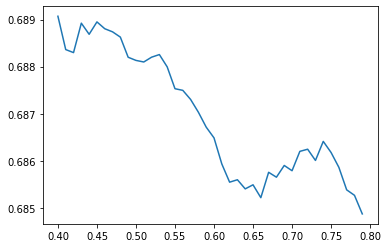

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6522907630471794 using the validated threshold of 0.4 

*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7190167968224723 with a threshold of 0.6300000000000002 



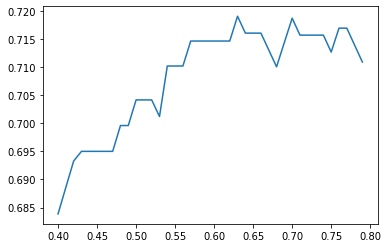

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6536631412428678 using the validated threshold of 0.6300000000000002 



In [ ]:
# model_scorer_debug = ModelScorer(trainer, val_predictions.predictions, test_predictions.predictions, chunked_encoded_dataset)
model_scorer = ModelScorer(trainer, chunked_encoded_dataset)
model_scorer.get_segmented_f1_scores()
model_scorer.get_book_f1_scores()

### BIGBIRD_2048

In [ ]:
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_PROJECT=goodreads_success_predictor


In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

ValueError: ignored

In [ ]:
from transformers import AutoModelForSequenceClassification

In [ ]:
import wandb
run = wandb.init(project = 'goodreads_success_predictor', name = 'bigbird2048')
artifact = run.use_artifact('lucaguarro/huggingface/model-2i1mpcr9:v0', type='model')
artifact_dir = artifact.download()

# Load your Hugging Face model from that folder
# using the same model class
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir, num_labels=2)

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact model-2i1mpcr9:v0, 488.82MB. 3 files... Done. 0:0:0
Some weights of the model checkpoint at ./artifacts/model-2i1mpcr9:v0 were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    'goodreads_predictor_grBERT',
    # output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    per_device_train_batch_size = 1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    gradient_accumulation_steps = 4,
    logging_steps=10,
    evaluation_strategy = "steps",
    eval_steps = 454, # prob better if set to 601 that way it evenly divides into the epochs
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_f1',
    report_to = "wandb"
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
454,0.608300,0.607716,0.722394,0.605962,0.521853,0.722394,1448.580800,1.788000
908,0.630600,0.594059,0.722394,0.605962,0.521853,0.722394,1424.369700,1.818000
1362,0.632700,0.592987,0.722394,0.605962,0.521853,0.722394,1419.847400,1.824000
1816,0.516400,0.596817,0.722394,0.605962,0.521853,0.722394,1416.908200,1.828000
2270,0.586700,0.591199,0.722394,0.605962,0.521853,0.722394,1476.623500,1.754000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

KeyboardInterrupt: ignored

### DistilBERT 512

#### Training

In [ ]:
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_PROJECT=goodreads_success_predictor


In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

In [ ]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.resize_token_embeddings(len(tokenizer))

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    'DISTILBert-512-32-w-50overlap',
    # output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    learning_rate=0.00005,
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=19,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "steps",
    eval_steps = 5, # prob better if set to 601 that way it evenly divides into the epochs
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_f1',
    greater_is_better = True,
    report_to = "wandb"
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],         # training dataset             # evaluation dataset
    eval_dataset=chunked_encoded_dataset['validation'], 
    compute_metrics = compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
5,No log,0.648036,0.726027,0.610785,0.527116,0.726027
10,0.661700,0.578792,0.726027,0.610785,0.527116,0.726027
15,0.661700,0.590026,0.726027,0.610785,0.527116,0.726027
20,0.596800,0.586080,0.726027,0.610785,0.527116,0.726027
25,0.596800,0.574831,0.726027,0.610785,0.527116,0.726027
30,0.634100,0.572229,0.726027,0.610785,0.527116,0.726027
35,0.634100,0.556028,0.726027,0.610785,0.527116,0.726027
40,0.588100,0.561690,0.726027,0.610785,0.527116,0.726027
45,0.588100,0.548612,0.726027,0.610785,0.527116,0.726027
50,0.570900,0.542481,0.726027,0.610785,0.527116,0.726027


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

#### Prediction

##### Using sentence tokenized dataset

###### First we will get the results using the model that had the lowest validation loss

In [ ]:
from transformers import AutoModelForSequenceClassification

run = wandb.init(project = 'goodreads_success_predictor')
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-1rmxb45c:v0', type='model')
artifact_dir = artifact.download()

# Load your Hugging Face model from that folder
# using the same model class
model1 = AutoModelForSequenceClassification.from_pretrained(artifact_dir, num_labels=2)

wandb: Downloading large artifact model-1rmxb45c:v0, 255.46MB. 3 files... Done. 0:0:0


In [ ]:
trainer = Trainer(
    model=model1,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

Getting predictions on validation set


Getting predictions on test set
*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7126996280836797 with a threshold of 0.5700000000000002 



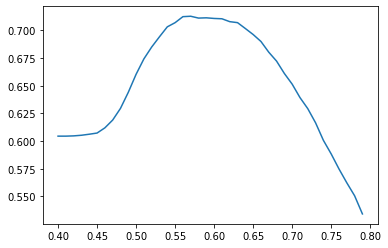

*****SCORE ON TEST SET*****
The weighted f1 score is 0.644050782253274 using the validated threshold of 0.5700000000000002 

*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.73920648586402 with a threshold of 0.6400000000000002 



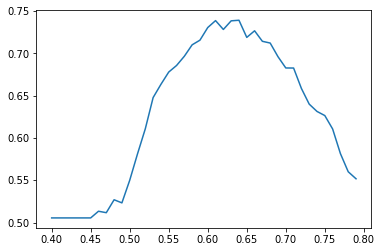

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6613333908552385 using the validated threshold of 0.6400000000000002 



In [ ]:
# model_scorer_debug = ModelScorer(trainer, val_predictions.predictions, test_predictions.predictions, chunked_encoded_dataset)
model_scorer_debug = ModelScorer(trainer, chunked_encoded_dataset)
model_scorer_debug.get_segmented_f1_scores()
model_scorer_debug.get_book_f1_scores()

###### Now we will get the results using the model that had the higest f1 score on validation set

In [ ]:
from transformers import AutoModelForSequenceClassification

run = wandb.init(project = 'goodreads_success_predictor')
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-2hvgulj8:v0', type='model')
artifact_dir = artifact.download()

model1 = AutoModelForSequenceClassification.from_pretrained(artifact_dir, num_labels=2)

wandb: Downloading large artifact model-2hvgulj8:v0, 255.46MB. 3 files... Done. 0:0:0


In [ ]:
trainer = Trainer(
    model=model1,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

Getting predictions on validation set


Getting predictions on test set
*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7238481572618374 with a threshold of 0.5200000000000001 



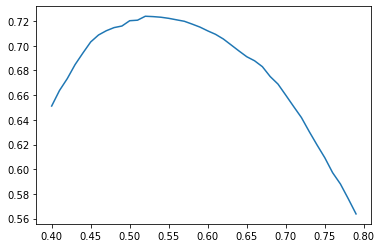

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6701392900457945 using the validated threshold of 0.5200000000000001 

*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7499600725952812 with a threshold of 0.6400000000000002 



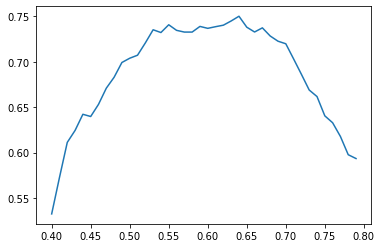

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6791253172207998 using the validated threshold of 0.6400000000000002 



In [ ]:
model_scorer_debug = ModelScorer(trainer, chunked_encoded_dataset)
model_scorer_debug.get_segmented_f1_scores()
model_scorer_debug.get_book_f1_scores()

##### Using overlap tokenized dataset

###### Using the model that had the lowest validation loss

In [ ]:
from transformers import AutoModelForSequenceClassification
import wandb
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-1sb5l5h5:v0', type='model')
artifact_dir = artifact.download()

model = AutoModelForSequenceClassification.from_pretrained(artifact_dir, num_labels=2)

wandb: Downloading large artifact model-1sb5l5h5:v0, 255.46MB. 3 files... Done. 0:0:0
loading configuration file ./artifacts/model-1sb5l5h5:v0/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.8.1",
  "vocab_size": 30523
}

loading weights file ./artifacts/model-1sb5l5h5:v0/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were init

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('label', 'labels')

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 11023
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 10816
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7187960795921114 with a threshold of 0.5200000000000001 



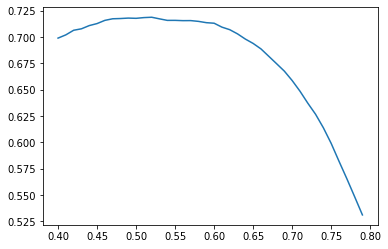

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6620510333975208 using the validated threshold of 0.5200000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7625886992728125 with a threshold of 0.5900000000000002 



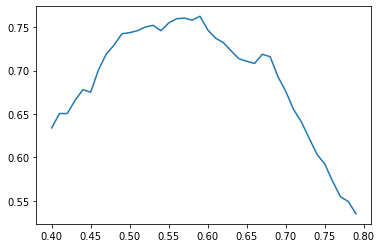

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6601641287461135 using a threshold of 0.5 

The weighted f1 score is 0.6802895477545781 using the validated threshold of 0.5900000000000002 



In [ ]:
model_scorer_debug = ModelScorer(trainer, chunked_encoded_dataset)
model_scorer_debug.get_segmented_f1_scores()
model_scorer_debug.get_book_f1_scores()

### ELECTRA Small

##### Training

In [ ]:
from transformers import ElectraForSequenceClassification

model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=2)
model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

Embedding(30523, 128)

In [ ]:
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_PROJECT=goodreads_success_predictor


In [ ]:
from transformers import ElectraTokenizerFast

tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-small-discriminator', additional_special_tokens = ['[CHARACTER]'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')
chunked_encoded_dataset = chunked_encoded_dataset.shuffle()

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    'nopretrain_ELECTRA_small_512_hp_tuned1',
    # output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    learning_rate=0.00001534,
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    weight_decay=0.1482,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "steps",
    eval_steps = 440, # prob better if set to 601 that way it evenly divides into the epochs
    save_total_limit = 30,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_f1',
    report_to = "wandb"
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],         # training dataset             # evaluation dataset
    eval_dataset=chunked_encoded_dataset['validation'], 
    compute_metrics = compute_metrics
)

trainer.train()

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
5,No log,0.673701,0.721333,0.604660,0.798996,0.721333
10,0.672900,0.649987,0.721232,0.604422,0.520175,0.721232
15,0.672900,0.634747,0.721232,0.604422,0.520175,0.721232
20,0.643700,0.623072,0.721232,0.604422,0.520175,0.721232
25,0.643700,0.614599,0.721232,0.604422,0.520175,0.721232
30,0.620300,0.608348,0.721232,0.604422,0.520175,0.721232
35,0.620300,0.603701,0.721232,0.604422,0.520175,0.721232
40,0.579100,0.599679,0.721232,0.604422,0.520175,0.721232
45,0.579100,0.596899,0.721232,0.604422,0.520175,0.721232
50,0.646100,0.595658,0.721232,0.604422,0.520175,0.721232


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

##### Prediction

In [ ]:
from transformers import AutoModelForSequenceClassification

run = wandb.init(project = 'goodreads_success_predictor')
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-11sw9jfw:v0', type='model')
artifact_dir = artifact.download()

# Load your Hugging Face model from that folder
# using the same model class
model1 = AutoModelForSequenceClassification.from_pretrained(artifact_dir, num_labels=2)

wandb: Downloading large artifact model-11sw9jfw:v0, 51.78MB. 3 files... Done. 0:0:0


In [ ]:
trainer = Trainer(
    model=model1,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

Getting predictions on validation set


Getting predictions on test set
*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7040316258734854 with a threshold of 0.4900000000000001 



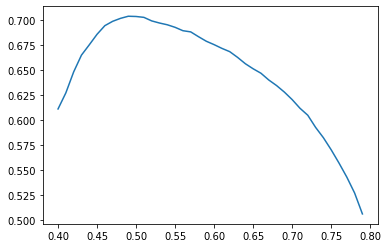

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6625952584591105 using the validated threshold of 0.4900000000000001 

*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7356141823268261 with a threshold of 0.5300000000000001 



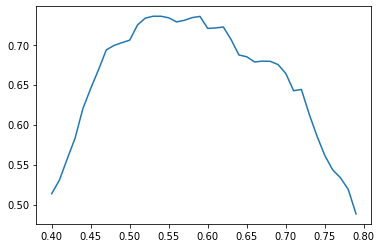

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6694912572125578 using the validated threshold of 0.5300000000000001 



In [ ]:
model_scorer = ModelScorer(trainer, chunked_encoded_dataset)
model_scorer.get_segmented_f1_scores()
model_scorer.get_book_f1_scores()

### ELECTRA 256

#### Training

In [ ]:
%env WANDB_PROJECT=goodreads_success_predictor

from transformers import ElectraForSequenceClassification, ElectraTokenizerFast

tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-large-discriminator', additional_special_tokens = ['[CHARACTER]'])

env: WANDB_PROJECT=goodreads_success_predictor


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label','labels')

In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.shuffle()

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    'nopretrain_ELECTRA-large-256',
    # output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "steps",
    eval_steps = 847, # prob better if set to 601 that way it evenly divides into the epochs
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_f1',
    report_to = "wandb"
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

model = ElectraForSequenceClassification.from_pretrained('google/electra-large-discriminator', num_labels=2)
model.resize_token_embeddings(len(tokenizer))

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],         # training dataset             # evaluation dataset
    eval_dataset=chunked_encoded_dataset['validation'], 
    compute_metrics = compute_metrics
)

trainer.train()

Some weights of the model checkpoint at google/electra-large-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-large-discriminator and are newly initialized: ['classifier

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
847,0.623600,0.592651,0.720897,0.603979,0.519693,0.720897
1694,0.575900,0.601575,0.720897,0.603979,0.519693,0.720897
2541,0.587200,0.592839,0.720897,0.603979,0.519693,0.720897
3388,0.550700,0.592113,0.720897,0.603979,0.519693,0.720897
4235,0.634000,0.592140,0.720897,0.603979,0.519693,0.720897
5082,0.623300,0.594547,0.720897,0.603979,0.519693,0.720897
5929,0.656900,0.598831,0.720897,0.603979,0.519693,0.720897
6776,0.591600,0.592176,0.720897,0.603979,0.519693,0.720897
7623,0.639500,0.593987,0.720897,0.603979,0.519693,0.720897
8470,0.667000,0.592855,0.720897,0.603979,0.519693,0.720897


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

TrainOutput(global_step=10164, training_loss=0.6135952867236207, metrics={'train_runtime': 23521.3491, 'train_samples_per_second': 0.432, 'total_flos': 0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 1341391360, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -1289502720, 'train_mem_gpu_alloc_delta': 4024187392, 'train_mem_cpu_peaked_delta': 1292828672, 'train_mem_gpu_peaked_delta': 0})

#### Prediction

In [ ]:
from transformers import AutoModelForSequenceClassification

run = wandb.init(project = 'goodreads_success_predictor')
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/nopretrain-ELECTRA256:v0', type='model')
artifact_dir = artifact.download()

# Load your Hugging Face model from that folder
# using the same model class
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir, num_labels=2)

train/loss,0.3248
train/learning_rate,0.0
train/epoch,3.0
train/global_step,2544
_runtime,634
_timestamp,1620939646
_step,260
eval/loss,0.93381
eval/accuracy,0.57838
eval/f1,0.59995
eval/precision,0.66207


train/loss,█▇▆▇▇▆▇▆▆▆▆▆▆▆▆▅▄▅▅▅▅▃▄▄▄▄▂▃▂▂▂▂▃▂▂▂▁▂▂▂
train/learning_rate,▁▂▃▄▅▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval/loss,▁▁▃▇▆█
eval/accuracy,█▇▅▁▄▃
eval/f1,▄█▆▁▅▃
eval/precision,▅█▁▄▂▂


wandb: Downloading large artifact nopretrain-ELECTRA256:v0, 51.78MB. 3 files... Done. 0:0:0


In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

In [ ]:
evaluations = trainer.predict(chunked_encoded_dataset['validation'])

In [ ]:
print(f1_score(chunked_encoded_dataset['validation']['labels'], np.round(softmax(evaluations.predictions, axis=1)[:,1]), average = 'weighted'))

0.6943129193633558


This is the correct reported value so we know we are getting the right model

In [ ]:
book_changes_idx = [i for i in range(1,len(chunked_encoded_dataset['validation']['book_title'])) if chunked_encoded_dataset['validation']['book_title'][i]!=chunked_encoded_dataset['validation']['book_title'][i-1]]
book_changes_idx.insert(0,0)
y_true = list( chunked_encoded_dataset['validation']['success_label'][i] for i in book_changes_idx )

avg_book_scores = get_average_book_scores(evaluations.predictions, book_changes_idx)
probabilities_per_book = softmax(avg_book_scores, axis = 1)
y_score = probabilities_per_book[:,1].tolist()

In [ ]:
import math
threshold = 0.50
y_pred = [math.floor(input) if input < threshold else math.ceil(input) for input in y_score]

print(f1_score(y_true, y_pred, average = 'weighted'))

0.7428576293863651


In [ ]:
test_evaluations = trainer.predict(chunked_encoded_dataset['test'])

In [ ]:
book_changes_idx = [i for i in range(1,len(chunked_encoded_dataset['test']['book_title'])) if chunked_encoded_dataset['test']['book_title'][i]!=chunked_encoded_dataset['test']['book_title'][i-1]]
book_changes_idx.insert(0,0)
y_true = list( chunked_encoded_dataset['test']['success_label'][i] for i in book_changes_idx )

avg_book_scores = get_average_book_scores(test_evaluations.predictions, book_changes_idx)
probabilities_per_book = softmax(avg_book_scores, axis = 1)
y_score = probabilities_per_book[:,1].tolist()

In [ ]:
threshold = 0.50
y_pred = [math.floor(input) if input < threshold else math.ceil(input) for input in y_score]

print(f1_score(y_true, y_pred, average = 'weighted'))

0.6573444376274642


### ELECTRA 512 - base

When fine-tuning for the downstream task with ELECTRA, we want to throw out the generator and use only the discriminator.

#### Training

##### Select Model

In [ ]:
from transformers import ElectraForSequenceClassification

model = None
no_pretrain = True
if no_pretrain:
  print("Getting standard ELECTRA model")
  model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=2)
  model.resize_token_embeddings(len(tokenizer))
else:
  model = ElectraForSequenceClassification.from_pretrained('/content/drive/MyDrive/Thesis/Models/ELECTRA_pretrained', num_labels=2)

Getting standard ELECTRA model


Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

In [ ]:
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_PROJECT=goodreads_success_predictor


In [ ]:
from transformers import ElectraTokenizerFast

tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-base-discriminator', additional_special_tokens = ['[CHARACTER]'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')
chunked_encoded_dataset = chunked_encoded_dataset.shuffle()

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    'nonpretrained_ELECTRA_512_32',
    # output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    learning_rate = 0.00001534,
    warmup_steps=440,                # number of warmup steps for learning rate scheduler
    weight_decay=0.1482,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=5,
    evaluation_strategy = "steps",
    eval_steps = 10, # prob better if set to 601 that way it evenly divides into the epochs
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_f1',
    report_to = "wandb"
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],         # training dataset             # evaluation dataset
    eval_dataset=chunked_encoded_dataset['validation'], 
    compute_metrics = compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.705900,0.710855,0.278667,0.121507,0.077691,0.278667
20,0.709200,0.703481,0.280288,0.128397,0.533081,0.280288
30,0.688900,0.692624,0.533934,0.554175,0.588104,0.533934
40,0.674400,0.677675,0.720523,0.606500,0.630272,0.720523
50,0.665500,0.660267,0.721130,0.604750,0.631727,0.721130
60,0.652600,0.644380,0.721029,0.604323,0.520135,0.721029
70,0.625800,0.626192,0.721029,0.604323,0.520135,0.721029
80,0.574300,0.609608,0.721029,0.604323,0.520135,0.721029
90,0.649600,0.600092,0.721232,0.604422,0.520175,0.721232
100,0.623700,0.597158,0.721232,0.604422,0.520175,0.721232


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

KeyboardInterrupt: ignored

In [ ]:
# import wandb
# run = wandb.init(project = 'goodreads_success_predictor', name = 'ElectraGoodreadsPredictor')

# model_name = 'google/electra-small-discriminator'
# artifact = run.use_artifact(model_name)
# artifact_dir = artifact.download()

# # Load your Hugging Face model from that folder
# # using the same model class
# model = AutoModelForSequenceClassification.from_pretrained(artifact_dir, num_labels=2)

#### Prediction

In [ ]:
from transformers import AutoModelForSequenceClassification

run = wandb.init(project = 'goodreads_success_predictor')
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/nopretrain-ELECTRA:v0', type='model')
artifact_dir = artifact.download()

# Load your Hugging Face model from that folder
# using the same model class
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir, num_labels=2)

wandb: Downloading large artifact nopretrain-ELECTRA:v0, 51.78MB. 3 files... Done. 0:0:0


In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

In [ ]:
evaluations = trainer.predict(chunked_encoded_dataset['validation'])

In [ ]:
book_changes_idx = [i for i in range(1,len(chunked_encoded_dataset['validation']['book_title'])) if chunked_encoded_dataset['validation']['book_title'][i]!=chunked_encoded_dataset['validation']['book_title'][i-1]]
book_changes_idx.insert(0,0)
y_true = list( chunked_encoded_dataset['validation']['success_label'][i] for i in book_changes_idx )

avg_book_scores = get_average_book_scores(evaluations.predictions, book_changes_idx)
probabilities_per_book = softmax(avg_book_scores, axis = 1)
y_score = probabilities_per_book[:,1].tolist()

In [ ]:
import math
threshold = 0.61
y_pred = [math.floor(input) if input < threshold else math.ceil(input) for input in y_score]

print(f1_score(y_true, y_pred, average = 'weighted'))

In [ ]:
test_evaluations = trainer.predict(chunked_encoded_dataset['test'])

In [ ]:
get_counts_of_classes(evaluations)

array([1313, 8559])

In [ ]:
import math
threshold = 0.61
y_pred = [math.floor(input) if input < threshold else math.ceil(input) for input in y_score]

print(f1_score(y_true, y_pred, average = 'weighted'))

0.7367114651027096


In [ ]:
get_counts_of_classes(test_evaluations)

array([1188, 8524])

In [ ]:
book_changes_idx = [i for i in range(1,len(chunked_encoded_dataset['test']['book_title'])) if chunked_encoded_dataset['test']['book_title'][i]!=chunked_encoded_dataset['test']['book_title'][i-1]]
book_changes_idx.insert(0,0)
y_true = list( chunked_encoded_dataset['test']['success_label'][i] for i in book_changes_idx )

avg_book_scores = get_average_book_scores(test_evaluations.predictions, book_changes_idx)
probabilities_per_book = softmax(avg_book_scores, axis = 1)
y_score = probabilities_per_book[:,1].tolist()

In [ ]:
threshold = 0.61
y_pred = [math.floor(input) if input < threshold else math.ceil(input) for input in y_score]

print(f1_score(y_true, y_pred, average = 'weighted'))

0.6733223419819482


In [ ]:
print(f1_score(y_true, [1] * len(y_true), average = 'weighted'))

0.5055880864599146


### ELECTRA 512 - large

In [ ]:
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_PROJECT=goodreads_success_predictor


In [ ]:
from transformers import ElectraForSequenceClassification, ElectraTokenizerFast

tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-large-discriminator', additional_special_tokens = ['[CHARACTER]'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    'nopretrain_ELECTRA',
    # output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    gradient_accumulation_steps = 2,
    evaluation_strategy = "steps",
    eval_steps = 454, # prob better if set to 601 that way it evenly divides into the epochs
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_f1',
    report_to = "wandb"
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

model = ElectraForSequenceClassification.from_pretrained('google/electra-large-discriminator', num_labels=2)
model.resize_token_embeddings(len(tokenizer))

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],         # training dataset             # evaluation dataset
    eval_dataset=chunked_encoded_dataset['validation'], 
    compute_metrics = compute_metrics
)

trainer.train()

Some weights of the model checkpoint at google/electra-large-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-large-discriminator and are newly initialized: ['classifier

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
454,0.648600,0.594074,0.721232,0.604422,0.520175,0.721232
908,0.580100,0.591786,0.721232,0.604422,0.520175,0.721232
1362,0.561300,0.591796,0.721232,0.604422,0.520175,0.721232
1816,0.670700,0.601176,0.721232,0.604422,0.520175,0.721232
2270,0.612100,0.591787,0.721232,0.604422,0.520175,0.721232
2724,0.582900,0.592177,0.721232,0.604422,0.520175,0.721232
3178,0.591900,0.592260,0.721232,0.604422,0.520175,0.721232
3632,0.636300,0.598448,0.721232,0.604422,0.520175,0.721232
4086,0.612400,0.591790,0.721232,0.604422,0.520175,0.721232
4540,0.645500,0.592441,0.721232,0.604422,0.520175,0.721232


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

TrainOutput(global_step=5277, training_loss=0.6148321493480249, metrics={'train_runtime': 17012.9876, 'train_samples_per_second': 0.31, 'total_flos': 2330935891869696.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 1341391360, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -203685888, 'train_mem_gpu_alloc_delta': 4024211968, 'train_mem_cpu_peaked_delta': 210046976, 'train_mem_gpu_peaked_delta': 0})

### Longformer 4096

In [ ]:
%env WANDB_PROJECT=goodreads_success_predictor

from transformers import LongformerForSequenceClassification, LongformerTokenizer

tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096', additional_special_tokens = ['[CHARACTER]'])

env: WANDB_PROJECT=goodreads_success_predictor


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label','labels')

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    'nopretrain_Longformer4096',
    # output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=1,  # batch size per device during training
    per_device_eval_batch_size=1,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "epoch",
    # eval_steps = 424, # prob better if set to 601 that way it evenly divides into the epochs
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_f1',
    report_to = "wandb"
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=2)
model.resize_token_embeddings(len(tokenizer))

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],         # training dataset             # evaluation dataset
    eval_dataset=chunked_encoded_dataset['validation'], 
    compute_metrics = compute_metrics
)

trainer.train()

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weigh

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.136900,1.093499,0.726246,0.611075,0.527433,0.726246
2,0.017700,1.216866,0.726246,0.611075,0.527433,0.726246
3,0.416500,1.095609,0.726246,0.611075,0.527433,0.726246


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=6384, training_loss=1.191052527053989, metrics={'train_runtime': 10511.86, 'train_samples_per_second': 0.607, 'total_flos': 0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 4096, 'init_mem_gpu_alloc_delta': 600159232, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -18161664, 'train_mem_gpu_alloc_delta': 1817487872, 'train_mem_cpu_peaked_delta': 19263488, 'train_mem_gpu_peaked_delta': 0})

### ROBERTA 512

In [ ]:
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_PROJECT=goodreads_success_predictor


In [ ]:
from transformers import AutoModelForSequenceClassification

In [ ]:
import wandb
run = wandb.init(project = 'goodreads_success_predictor', name = 'run2')
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/mlm_ROBERTA:v0', type='model')
artifact_dir = artifact.download()

# Load your Hugging Face model from that folder
# using the same model class
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir, num_labels=2)

wandb: Downloading large artifact mlm_ROBERTA:v0, 475.78MB. 3 files... Done. 0:0:0
Some weights of the model checkpoint at ./artifacts/mlm_ROBERTA:v0 were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./artifacts/mlm_R

In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    'goodreads_predictor_grROBERTA',
    # output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "steps",
    eval_steps = 454, # prob better if set to 601 that way it evenly divides into the epochs
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_f1',
    report_to = "wandb"
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
454,0.491000,0.548852,0.731197,0.617663,0.534648,0.731197
908,0.646300,0.585508,0.731197,0.617663,0.534648,0.731197


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: ignored

In [ ]:
f1_score(chunked_encoded_dataset['validation']['labels'], [1]*len(chunked_encoded_dataset['validation']['labels']), average = 'weighted')

0.617663410027467

## Genre-Aware Classification

This section frames the problem as a multi-task classification problem. In which given the text, the model aims to predict both the genre and whether it is successful or not.

### Extend Huggingface Transformers for Multi-Task Classification

#### BERT Extension

In [ ]:
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput
from torch import nn
import torch
from torch.nn import CrossEntropyLoss, MSELoss

class BertForMultipleSequenceClassification(BertPreTrainedModel):
    def __init__(self, config, num_labels1 = 2, num_labels2 = 8):
        super().__init__(config)
        self.num_labels1 = num_labels1
        self.num_labels2 = num_labels2
        print(self.num_labels1, self.num_labels2)
        self.alpha = .5
        self.config = config

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier1 = nn.Linear(config.hidden_size, self.num_labels1)
        self.classifier2 = nn.Linear(config.hidden_size, self.num_labels2)

        self.init_weights()


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits1 = self.classifier1(pooled_output)
        logits2 = self.classifier2(pooled_output)
        logits = torch.cat([logits1, logits2], 1)
        loss = None
        if labels is not None:
            #if self.config.problem_type is None:
            #self.config.problem_type = "single_label_classification"
            
            if self.num_labels1 > 1:
                loss_fct1 = CrossEntropyLoss()
                loss1 = loss_fct1(logits1.view(-1, self.num_labels1), labels[:, 0].view(-1))
            else:
                loss_fct1 = MSELoss()
                loss1 = loss_fct1(logits1.view(-1), labels[:, 0].view(-1))

            if self.num_labels2 > 1:
                loss_fct2 = CrossEntropyLoss()
                loss2 = loss_fct2(logits2.view(-1, self.num_labels2), labels[:, 1].view(-1))
            else:
                loss_fct2 = MSELoss()
                loss2 = loss_fct2(logits2.view(-1), labels[:, 1].view(-1))
            loss = self.alpha*loss1 + (1-self.alpha)*loss2 

        if not return_dict:
            output = (logits,) + outputs[2:] #not sure if this works
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

#### DistilBERT Extension

In [ ]:
from transformers import DistilBertPreTrainedModel, DistilBertModel
from transformers.modeling_outputs import SequenceClassifierOutput
from torch import nn
import torch
from torch.nn import CrossEntropyLoss, MSELoss

class DistilBERTForMultipleSequenceClassification(DistilBertPreTrainedModel):
    def __init__(self, config, num_labels1 = 2, num_labels2 = 4):
        super().__init__(config)
        self.num_labels1 = num_labels1
        self.num_labels2 = num_labels2
        print(self.num_labels1, self.num_labels2)
        self.alpha = .5
        self.config = config

        self.distilbert = DistilBertModel(config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier1 = nn.Linear(config.dim, self.num_labels1)
        self.classifier2 = nn.Linear(config.dim, self.num_labels2)
        self.dropout = nn.Dropout(config.dropout)

        self.init_weights()


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
              input_ids=input_ids,
              attention_mask=attention_mask,
              head_mask=head_mask,
              inputs_embeds=inputs_embeds,
              output_attentions=output_attentions,
              output_hidden_states=output_hidden_states,
              return_dict=return_dict,
          )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits1 = self.classifier1(pooled_output)
        logits2 = self.classifier2(pooled_output)
        logits = torch.cat([logits1, logits2], 1)

        loss = None
        if labels is not None:
            #if self.config.problem_type is None:
            #self.config.problem_type = "single_label_classification"
            
            if self.num_labels1 > 1:
                loss_fct1 = CrossEntropyLoss()
                loss1 = loss_fct1(logits1.view(-1, self.num_labels1), labels[:, 0].view(-1))
            else:
                loss_fct1 = MSELoss()
                loss1 = loss_fct1(logits1.view(-1), labels[:, 0].view(-1))

            if self.num_labels2 > 1:
                loss_fct2 = CrossEntropyLoss()
                loss2 = loss_fct2(logits2.view(-1, self.num_labels2), labels[:, 1].view(-1))
            else:
                loss_fct2 = MSELoss()
                loss2 = loss_fct2(logits2.view(-1), labels[:, 1].view(-1))
            loss = self.alpha*loss1 + (1-self.alpha)*loss2 

        if not return_dict:
            output = (logits,) + outputs[2:] #not sure if this works
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states, #hidden_states,
            attentions=distilbert_output.attentions, #attentions,
        )

### Map Dataset to Multitask Problem

In [ ]:
import numpy as np
# When batched = True, we take in multiple examples
def group_success_and_genre(examples):
  examples['labels'] = np.vstack((examples['success_label'], examples['genre'])).T
  return examples

In [ ]:
chunked_encoded_dataset = chunked_encoded_dataset.map(group_success_and_genre, batched = True, remove_columns=['genre', 'success_label'])

### BertForMultipleSequenceClassification

#### Training

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', additional_special_tokens = ['[CHARACTER]'])
# use the new class as the older one
model = BertForMultipleSequenceClassification.from_pretrained('bert-base-uncased', num_labels1 = 2, num_labels2 = 8)
model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2 8


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMultipleSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleSequenceClassification were not initiali

Embedding(30523, 768)

In [ ]:
def compute_metrics(pred):
  preds = pred.predictions
  label_ids = pred.label_ids

  success_labels = label_ids[:, 0]
  genre_labels = label_ids[:, 1]

  success_preds = preds[:, 0:2].argmax(1)
  genre_preds = preds[:, 2:6].argmax(1)

  s_precision, s_recall, s_f1, _ = precision_recall_fscore_support(success_labels, success_preds, average='weighted')
  s_acc = accuracy_score(success_labels, success_preds)

  g_precision, g_recall, g_f1, _ = precision_recall_fscore_support(genre_labels, genre_preds, average='weighted')
  g_acc = accuracy_score(success_labels, success_preds)

  return {
      's_accuracy': s_acc,
      's_f1': s_f1,
      's_precision': s_precision,
      's_recall': s_recall,
      'g_accuracy': g_acc,
      'g_f1': g_f1,
      'g_precision': g_precision,
      'g_recall': g_recall
  }

training_args = TrainingArguments(
    'BERT_512_multitask_test',
    # output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    learning_rate=0.00005,
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    # weight_decay=0.1482,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "steps",
    save_total_limit = 30,
    eval_steps = 10, # each epoch is 880 steps
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_s_f1',
    greater_is_better = True,
    report_to = "wandb"
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],         # training dataset             # evaluation dataset
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

In [ ]:
trainer.train()

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


Step,Training Loss,Validation Loss,S Accuracy,S F1,S Precision,S Recall,G Accuracy,G F1,G Precision,G Recall
10,1.367500,1.274993,0.721232,0.604422,0.520175,0.721232,0.721232,0.021535,0.012124,0.106361
20,1.284200,1.330456,0.721232,0.604422,0.520175,0.721232,0.721232,0.022758,0.012668,0.111831
30,1.337200,1.236645,0.721232,0.604422,0.520175,0.721232,0.721232,0.073827,0.051135,0.163898
40,1.239700,1.192803,0.721232,0.604422,0.520175,0.721232,0.721232,0.073664,0.053915,0.154781
50,1.181600,1.129247,0.721232,0.604422,0.520175,0.721232,0.721232,0.076637,0.062153,0.181726
60,1.165500,1.230720,0.721232,0.604422,0.520175,0.721232,0.721232,0.064478,0.048493,0.157719
70,1.115100,1.093368,0.721232,0.604422,0.520175,0.721232,0.721232,0.089632,0.062976,0.193375
80,1.103700,1.100275,0.721232,0.604422,0.520175,0.721232,0.721232,0.100692,0.089939,0.195908
90,1.102400,1.056663,0.720624,0.605064,0.607330,0.720624,0.720624,0.123500,0.097773,0.217484
100,1.073600,1.004989,0.721434,0.604898,0.799049,0.721434,0.721434,0.129487,0.098816,0.229335


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

TrainOutput(global_step=1760, training_loss=0.5377748221158981, metrics={'train_runtime': 19718.3432, 'train_samples_per_second': 0.089, 'total_flos': 0, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1869299712, 'train_mem_gpu_alloc_delta': 1320830976, 'train_mem_cpu_peaked_delta': 270336, 'train_mem_gpu_peaked_delta': 0})

#### Prediction

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-kiwqvmdw:v0', type='model')
artifact_dir = artifact.download()

# Load your Hugging Face model from that folder
# using the same model class
model1 = BertForMultipleSequenceClassification.from_pretrained(artifact_dir, num_labels1 = 2, num_labels2 = 8)

def compute_metrics(pred):
  preds = pred.predictions
  label_ids = pred.label_ids

  success_labels = label_ids[:, 0]
  genre_labels = label_ids[:, 1]

  success_preds = preds[:, 0:2].argmax(1)
  genre_preds = preds[:, 2:6].argmax(1)

  s_precision, s_recall, s_f1, _ = precision_recall_fscore_support(success_labels, success_preds, average='weighted')
  s_acc = accuracy_score(success_labels, success_preds)

  g_precision, g_recall, g_f1, _ = precision_recall_fscore_support(genre_labels, genre_preds, average='weighted')
  g_acc = accuracy_score(success_labels, success_preds)

  return {
      's_accuracy': s_acc,
      's_f1': s_f1,
      's_precision': s_precision,
      's_recall': s_recall,
      'g_accuracy': g_acc,
      'g_f1': g_f1,
      'g_precision': g_precision,
      'g_recall': g_recall
  }

trainer = Trainer(
    model=model1,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact model-kiwqvmdw:v0, 417.76MB. 3 files... Done. 0:0:0


2 8


In [ ]:
# def __init__(self, devset_predictions, testset_predictions, segmented_dataset, for_multitask = False):
devset_predictions = trainer.predict(chunked_encoded_dataset['validation']).predictions
testset_predictions = trainer.predict(chunked_encoded_dataset['test']).predictions

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Getting predictions on validation set


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7243632459729273 with a threshold of 0.5000000000000001 



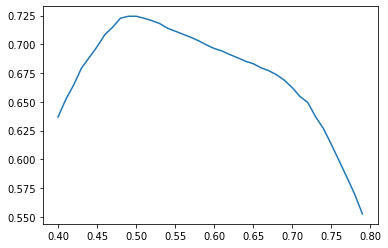

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6594544480379022 using the validated threshold of 0.5000000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7408432459939744 with a threshold of 0.5500000000000002 



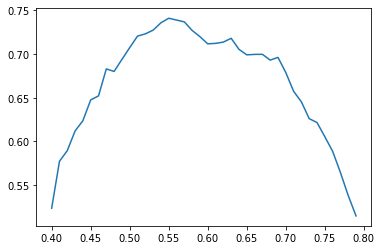

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6491740884524626 using a threshold of 0.5 

The weighted f1 score is 0.6602126680836651 using the validated threshold of 0.5500000000000002 



In [ ]:
# model_scorer= ModelScorer(devset_predictions, testset_predictions, chunked_encoded_dataset, True)
model_scorer = ModelScorer(trainer, chunked_encoded_dataset, True)
model_scorer.get_segmented_f1_scores()
model_scorer.get_book_f1_scores()

### DistilBertForMultipleSequenceClassification

#### Training

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', additional_special_tokens = ['[CHARACTER]'])
# use the new class as the older one
model = DistilBERTForMultipleSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels1 = 2, num_labels2 = 8)
model.resize_token_embeddings(len(tokenizer))

In [ ]:
def compute_metrics(pred):
  preds = pred.predictions
  label_ids = pred.label_ids

  success_labels = label_ids[:, 0]
  genre_labels = label_ids[:, 1]

  success_preds = preds[:, 0:2].argmax(1)
  genre_preds = preds[:, 2:6].argmax(1)

  s_precision, s_recall, s_f1, _ = precision_recall_fscore_support(success_labels, success_preds, average='weighted')
  s_acc = accuracy_score(success_labels, success_preds)

  g_precision, g_recall, g_f1, _ = precision_recall_fscore_support(genre_labels, genre_preds, average='weighted')
  g_acc = accuracy_score(success_labels, success_preds)

  return {
      's_accuracy': s_acc,
      's_f1': s_f1,
      's_precision': s_precision,
      's_recall': s_recall,
      'g_accuracy': g_acc,
      'g_f1': g_f1,
      'g_precision': g_precision,
      'g_recall': g_recall
  }

training_args = TrainingArguments(
    'DistilBERT_512_multitask_256overlap',
    # output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    learning_rate=0.00005,
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    # weight_decay=0.1482,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "steps",
    save_total_limit = 30,
    eval_steps = 10, # each epoch is 880 steps
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_s_f1',
    greater_is_better = True,
    report_to = "wandb"
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],         # training dataset             # evaluation dataset
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

In [ ]:
trainer.train()

#### Prediction

##### Using sentence tokenizer

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-2giwtwvy:v0', type='model')
artifact_dir = artifact.download()

In [ ]:
# Load your Hugging Face model from that folder
# using the same model class
model1 = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir, num_labels1 = 2, num_labels2 = 8)

def compute_metrics(pred):
  preds = pred.predictions
  label_ids = pred.label_ids

  success_labels = label_ids[:, 0]
  genre_labels = label_ids[:, 1]

  success_preds = preds[:, 0:2].argmax(1)
  genre_preds = preds[:, 2:6].argmax(1)

  s_precision, s_recall, s_f1, _ = precision_recall_fscore_support(success_labels, success_preds, average='weighted')
  s_acc = accuracy_score(success_labels, success_preds)

  g_precision, g_recall, g_f1, _ = precision_recall_fscore_support(genre_labels, genre_preds, average='weighted')
  g_acc = accuracy_score(success_labels, success_preds)

  return {
      's_accuracy': s_acc,
      's_f1': s_f1,
      's_precision': s_precision,
      's_recall': s_recall,
      'g_accuracy': g_acc,
      'g_f1': g_f1,
      'g_precision': g_precision,
      'g_recall': g_recall
  }

trainer = Trainer(
    model=model1,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

2 8


In [ ]:
# model_scorer = ModelScorer(devset_predictions, testset_predictions, chunked_encoded_dataset, True)
model_scorer = ModelScorer(trainer, chunked_encoded_dataset, True)
model_scorer.get_segmented_f1_scores()
model_scorer.get_book_f1_scores()

##### Using overlap tokenizer

###### Overlap of 50

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-nlpbosie:v0', type='model')
artifact_dir = artifact.download()

In [ ]:
# Load your Hugging Face model from that folder
# using the same model class
model1 = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir, num_labels1 = 2, num_labels2 = 8)

def compute_metrics(pred):
  preds = pred.predictions
  label_ids = pred.label_ids

  success_labels = label_ids[:, 0]
  genre_labels = label_ids[:, 1]

  success_preds = preds[:, 0:2].argmax(1)
  genre_preds = preds[:, 2:6].argmax(1)

  s_precision, s_recall, s_f1, _ = precision_recall_fscore_support(success_labels, success_preds, average='weighted')
  s_acc = accuracy_score(success_labels, success_preds)

  g_precision, g_recall, g_f1, _ = precision_recall_fscore_support(genre_labels, genre_preds, average='weighted')
  g_acc = accuracy_score(success_labels, success_preds)

  return {
      's_accuracy': s_acc,
      's_f1': s_f1,
      's_precision': s_precision,
      's_recall': s_recall,
      'g_accuracy': g_acc,
      'g_f1': g_f1,
      'g_precision': g_precision,
      'g_recall': g_recall
  }

trainer = Trainer(
    model=model1,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

2 8


In [ ]:
# model_scorer = ModelScorer(devset_predictions, testset_predictions, chunked_encoded_dataset, True)
model_scorer = ModelScorer(trainer, chunked_encoded_dataset, True)
model_scorer.get_segmented_f1_scores()
model_scorer.get_book_f1_scores()

###### Overlap of 256

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-1z47cnun:v0', type='model')
artifact_dir = artifact.download()

In [ ]:
# Load your Hugging Face model from that folder
# using the same model class
model1 = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir, num_labels1 = 2, num_labels2 = 8)

def compute_metrics(pred):
  preds = pred.predictions
  label_ids = pred.label_ids

  success_labels = label_ids[:, 0]
  genre_labels = label_ids[:, 1]

  success_preds = preds[:, 0:2].argmax(1)
  genre_preds = preds[:, 2:6].argmax(1)

  s_precision, s_recall, s_f1, _ = precision_recall_fscore_support(success_labels, success_preds, average='weighted')
  s_acc = accuracy_score(success_labels, success_preds)

  g_precision, g_recall, g_f1, _ = precision_recall_fscore_support(genre_labels, genre_preds, average='weighted')
  g_acc = accuracy_score(success_labels, success_preds)

  return {
      's_accuracy': s_acc,
      's_f1': s_f1,
      's_precision': s_precision,
      's_recall': s_recall,
      'g_accuracy': g_acc,
      'g_f1': g_f1,
      'g_precision': g_precision,
      'g_recall': g_recall
  }

trainer = Trainer(
    model=model1,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=chunked_encoded_dataset['validation'],
    compute_metrics = compute_metrics
)

2 8


In [ ]:
# model_scorer = ModelScorer(devset_predictions, testset_predictions, chunked_encoded_dataset, True)
model_scorer = ModelScorer(trainer, chunked_encoded_dataset, True)
model_scorer.get_segmented_f1_scores()
model_scorer.get_book_f1_scores()

## Transformer --> Embeddings --> Classifier

In this subsection, we will look into first getting the embeddings of the book chunks via BERT and then train either a shallow neural network or an SVM with these embeddings to learn our classification task

In [ ]:
from transformers import BertModel, BertTokenizer
import wandb
run = wandb.init(project = 'goodreads_success_predictor', name = 'run2')
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/mlm_BERT:v0', type='model')
artifact_dir = artifact.download()

# Load your Hugging Face model from that folder
# using the same model class
model = BertModel.from_pretrained(artifact_dir, num_labels=2)

wandb: Downloading large artifact mlm_BERT:v0, 413.38MB. 3 files... Done. 0:0:0
Some weights of BertModel were not initialized from the model checkpoint at ./artifacts/mlm_BERT:v0 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', additional_special_tokens = ['[CHARACTER]'])

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
model.resize_token_embeddings(len(tokenizer))

Embedding(28997, 768, padding_idx=0)

In [ ]:
from transformers import BatchEncoding

In [ ]:
type(chunked_encoded_dataset['train'].features)

datasets.features.Features

In [ ]:
input_test = tokenizer("we can play it by ear", return_tensors='pt')
print(type(input_test))
model(**input_test)

<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [ ]:
input_test

{'input_ids': [101, 1195, 1169, 1505, 1122, 1118, 3811, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

### Getting the Embeddings

## Transformer --> Classifier --> Chunk Embeddings --> Classifier

In this chapter we used already fine-tuned BERT models to extract the chunk embeddings of our books. The chunk embeddings correspond to either the meaned embeddings of all the words in the sequence or the embedding of the [CLS] token. We will explore the results of both. We will then run a variety of classifiers over these embeddings directly. 

1.   Meaned pooled output --> single layer NN
2.   RoBERT
3.   ToBERT ?



In [ ]:
import wandb
run = wandb.init()

model_name = 'DistilBERT_multitask_overlap50_dataset_embeddings'

artifact = None
if (model_name == 'DistilBERT_multitask_sentence_tokenized_dataset_embeddings'):
  artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-2giwtwvy:v0', type='model')
elif (model_name == 'DistilBERT_multitask_overlap50_dataset_embeddings'):
  artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-nlpbosie:v0', type='model')

artifact_dir = artifact.download()

model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir, num_labels1 = 2, num_labels2 = 8)
model.cuda()

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact model-nlpbosie:v0, 255.48MB. 3 files... Done. 0:0:0


2 8


DistilBERTForMultipleSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30523, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [ ]:
model.base_model_prefix

'distilbert'

### Get pooled outputs of dataset

#### From script

In [ ]:
import torch as th
import time

def get_book_changes_idx(book_titles):
  book_changes_idx = np.where(np.array(book_titles[:-1]) != np.array(book_titles[1:]))[0]
  book_changes_idx += 1
  book_changes_idx = np.insert(book_changes_idx, 0, 0)
  return book_changes_idx

def getPooledOutputs(model, encoded_dataset, batch_size = 32):
  model.eval()

  # pooled_outputs = []
  pooled_outputs = torch.empty([0,768]).cuda()

  num_iters = (len(encoded_dataset['input_ids']) - 1)//batch_size + 1
  print("total number of iters ", num_iters)
  
  for i in range(num_iters):
    print(i)
    up_to = i*batch_size + batch_size
    if len(encoded_dataset['input_ids']) < up_to:
      up_to = len(encoded_dataset['input_ids'])
    input_ids = th.LongTensor(encoded_dataset['input_ids'][i*batch_size:up_to]).cuda()
    attention_mask = th.LongTensor(encoded_dataset['attention_mask'][i*batch_size:up_to]).cuda()

    with torch.no_grad():
      embeddings = model.forward(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)['hidden_states'][-1][:,0] # Pooled output
      pooled_outputs = th.cat([pooled_outputs, embeddings],0)
      th.cuda.empty_cache()

  return pooled_outputs

def getAveragePooledOutputs(model, encoded_dataset):
  book_embeddings_dataset = {'meaned_pooled_output': [], 'book_title': [], 'genre': [], 'labels': []}

  book_changes = get_book_changes_idx(encoded_dataset['book_title'])

  for i in range(len(book_changes)):
    print(i)
    start = book_changes[i]
    end = None
    if i != len(book_changes) - 1:
      end = book_changes[i+1]
    else:
      end = len(encoded_dataset['input_ids'])

    input_ids = th.LongTensor(encoded_dataset['input_ids'][start:end])
    attention_mask = th.BoolTensor(encoded_dataset['attention_mask'][start:end])

    with torch.no_grad():
      embeddings = model.distilbert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)[0][:,0] # Pooled output
      book_embeddings = th.mean(embeddings, dim=0) # Takes the mean of the pooled output
    book_embeddings_dataset['meaned_pooled_output'].append(book_embeddings)
    book_embeddings_dataset['book_title'].append(encoded_dataset['book_title'][start])
    book_embeddings_dataset['genre'].append(encoded_dataset['genre'][start])
    book_embeddings_dataset['labels'].append(encoded_dataset['labels'][start])
  
  return book_embeddings_dataset

In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 15752
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 11023
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 10816
    })
})

In [ ]:
train_set_embeddings = getPooledOutputs(model, chunked_encoded_dataset['train'])

In [ ]:
val_set_embeddings = getPooledOutputs(model, chunked_encoded_dataset['validation'])

In [ ]:
test_set_embeddings = getPooledOutputs(model, chunked_encoded_dataset['test'])

In [ ]:
from datasets import Dataset
train_set_embeddings = Dataset.from_dict({'pooled_outputs': train_set_embeddings})
val_set_embeddings = Dataset.from_dict({'pooled_outputs': val_set_embeddings})
test_set_embeddings = Dataset.from_dict({'pooled_outputs': test_set_embeddings})

In [ ]:
from datasets import concatenate_datasets
dataset_w_embeddings = DatasetDict({
    'train': concatenate_datasets([chunked_encoded_dataset['train'], train_set_embeddings], axis = 1), 
    'validation': concatenate_datasets([chunked_encoded_dataset['validation'], val_set_embeddings], axis = 1), 
    'test': concatenate_datasets([chunked_encoded_dataset['test'], test_set_embeddings], axis = 1)
})
dataset_w_embeddings = dataset_w_embeddings.remove_columns(['attention_mask', 'input_ids', 'token_type_ids'])

In [ ]:
dataset_w_embeddings

DatasetDict({
    train: Dataset({
        features: ['book_title', 'genre', 'success_label', 'pooled_outputs'],
        num_rows: 15752
    })
    validation: Dataset({
        features: ['book_title', 'genre', 'success_label', 'pooled_outputs'],
        num_rows: 11023
    })
    test: Dataset({
        features: ['book_title', 'genre', 'success_label', 'pooled_outputs'],
        num_rows: 10816
    })
})

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

with open('train_ds.pkl', 'wb') as output_file:
  pickle.dump(dataset_w_embeddings['train'], output_file)

with open('val_ds.pkl', 'wb') as output_file:
  pickle.dump(dataset_w_embeddings['validation'], output_file)

with open('test_ds.pkl', 'wb') as output_file:
  pickle.dump(dataset_w_embeddings['test'], output_file)

folder_id = '176pNJFvgTaclx_dKNGgocd-TvwmqxM7Y'
# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('train_ds.pkl')
file.Upload() 

# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('val_ds.pkl')
file.Upload() 

# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('test_ds.pkl')
file.Upload() 

#### Load from Drive

In [ ]:
base_path = Path("/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/Pooled_Output/")

In [ ]:
from datasets import DatasetDict

if model_name == 'DistilBERT_multitask_sentence_tokenized_dataset_embeddings':
  full_directory = base_path / 'DistilBERT_multitask_sentence_tokenized_dataset_embeddings'
elif model_name == 'DistilBERT_multitask_overlap50_dataset_embeddings':
  print("ay")
  full_directory = base_path / 'DistilBERT_multitask_overlap50_dataset_embeddings'

with open(full_directory / 'train_ds.pkl', "rb") as input_file:
  train_set_embeddings = pickle.load(input_file)

with open(full_directory / 'val_ds.pkl', "rb") as input_file:
  val_set_embeddings = pickle.load(input_file)

with open(full_directory / 'test_ds.pkl', "rb") as input_file:
  test_set_embeddings = pickle.load(input_file)

dataset_w_embeddings = DatasetDict({'train': train_set_embeddings, 'validation': val_set_embeddings, 'test': test_set_embeddings})
dataset_w_embeddings

ay


DatasetDict({
    train: Dataset({
        features: ['book_title', 'genre', 'success_label', 'pooled_outputs'],
        num_rows: 15752
    })
    validation: Dataset({
        features: ['book_title', 'genre', 'success_label', 'pooled_outputs'],
        num_rows: 11023
    })
    test: Dataset({
        features: ['book_title', 'genre', 'success_label', 'pooled_outputs'],
        num_rows: 10816
    })
})

### Meaned pooled output --> single layer NN

#### Take mean of Pooled Outputs per Book

In [ ]:
def get_book_changes_idx(book_titles):
  book_changes_idx = np.where(np.array(book_titles[:-1]) != np.array(book_titles[1:]))[0]
  book_changes_idx += 1
  book_changes_idx = np.insert(book_changes_idx, 0, 0)
  return book_changes_idx

In [ ]:
def getAveragePooledOutputs(dataset_w_embeddings):
  book_embeddings_dataset = {}
  for split in dataset_w_embeddings:
    ds_curr_split = dataset_w_embeddings[split]

    book_changes_idx = get_book_changes_idx(ds_curr_split['book_title'])
    book_embeddings_for_split = {'meaned_pooled_output': [], 'book_title': [], 'genre': [], 'success_label': []}
    for i in range(len(book_changes_idx)):
      print(i)
      start = book_changes_idx[i]
      end = None
      if i != len(book_changes_idx) - 1:
        end = book_changes_idx[i+1]
      else:
        end = len(ds_curr_split['pooled_outputs'])

      chunk_embeddings = th.FloatTensor(ds_curr_split['pooled_outputs'][start:end])
      book_embeddings = th.mean(chunk_embeddings, dim=0) # Takes the mean of the pooled output

      book_embeddings_for_split['meaned_pooled_output'].append(book_embeddings)
      book_embeddings_for_split['book_title'].append(ds_curr_split['book_title'][start])
      book_embeddings_for_split['genre'].append(ds_curr_split['genre'][start])
      book_embeddings_for_split['success_label'].append(ds_curr_split['success_label'][start])
    
    book_embeddings_dataset[split] = book_embeddings_for_split
  return book_embeddings_dataset

In [ ]:
avg_pld_outs_ds = getAveragePooledOutputs(dataset_w_embeddings)

In [ ]:
from datasets import DatasetDict, Dataset
avg_pld_outs_hf_ds = DatasetDict({'train': Dataset.from_dict(avg_pld_outs_ds['train']), 'validation': Dataset.from_dict(avg_pld_outs_ds['validation']), 'test': Dataset.from_dict(avg_pld_outs_ds['test'])})

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

with open('avg_pld_outs_hf_ds.pkl', 'wb') as output_file:
  pickle.dump(avg_pld_outs_hf_ds, output_file)

folder_id = '176pNJFvgTaclx_dKNGgocd-TvwmqxM7Y'
# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('avg_pld_outs_hf_ds.pkl')
file.Upload() 


##### Load 'em

In [ ]:
from datasets import DatasetDict
with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/Pooled_Output/DistilBERT_multitask_dataset_embeddings/avg_pld_outs_hf_ds.pkl", "rb") as input_file:
  avg_pld_outs_hf_ds = pickle.load(input_file)

#### Create NN and Train

In [ ]:
avg_pld_outs_hf_ds

DatasetDict({
    train: Dataset({
        features: ['meaned_pooled_output', 'book_title', 'genre', 'success_label'],
        num_rows: 404
    })
    validation: Dataset({
        features: ['meaned_pooled_output', 'book_title', 'genre', 'success_label'],
        num_rows: 290
    })
    test: Dataset({
        features: ['meaned_pooled_output', 'book_title', 'genre', 'success_label'],
        num_rows: 290
    })
})

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers.modeling_outputs import SequenceClassifierOutput

class Net(nn.Module):

    def __init__(self, pre_classifier_init, classifier_init):
        super(Net, self).__init__()

        self.pre_classifier = nn.Linear(768, 768)
        self.classifier = nn.Linear(768, 2)
        self.dropout = nn.Dropout(0.1)

        self.pre_classifier.weight.data.copy_(pre_classifier_init.weight.data)
        self.classifier.weight.data.copy_(classifier_init.weight.data)

        # print(pre_classifier_init.bias.data)
        self.pre_classifier.bias.data.copy_(pre_classifier_init.bias.data)
        self.classifier.bias.data.copy_(classifier_init.bias.data)

        # DOUBLE CHECK IF BIASES ARE BEING SET AS WELL

    def forward(self, x, labels = None):
        # Max pooling over a (2, 2) window
        x = self.pre_classifier(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        logits = self.classifier(x)

        loss = None
        if labels is not None:
          loss_fct = CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return SequenceClassifierOutput(
            loss = loss,
            logits = logits
        )

net = Net(model.pre_classifier, model.classifier1)
print(net)

Net(
  (pre_classifier): Linear(in_features=768, out_features=768, bias=True)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
net.eval()

Net(
  (pre_classifier): Linear(in_features=768, out_features=768, bias=True)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

##### Results with no training

In [ ]:
with torch.no_grad():
  logits = net.forward(torch.FloatTensor(avg_pld_outs_hf_ds['validation']['meaned_pooled_output']))
y_score = softmax(logits['logits'], axis = 1)[:, 1].tolist()
y_pred = [math.floor(input) if input < 0.50 else math.ceil(input) for input in y_score]
f1_score(avg_pld_outs_hf_ds['validation']['success_label'], y_pred, average = 'weighted')

0.7470106924485553

In [ ]:
with torch.no_grad():
  logits = net.forward(torch.FloatTensor(avg_pld_outs_hf_ds['test']['meaned_pooled_output']))
y_score = softmax(logits['logits'], axis = 1)[:, 1].tolist()
y_pred = [math.floor(input) if input < 0.50 else math.ceil(input) for input in y_score]
f1_score(avg_pld_outs_hf_ds['test']['success_label'], y_pred, average = 'weighted')

0.6695484400656813

#### Results with training

In [ ]:
type(avg_pld_outs_hf_ds['train'])

datasets.arrow_dataset.Dataset

In [ ]:
avg_pld_outs_hf_ds.set_format(type='pytorch', columns=['meaned_pooled_output', 'success_label'])

In [ ]:
trainloader = torch.utils.data.DataLoader(avg_pld_outs_hf_ds['train'], batch_size=32)

In [ ]:
net.train()

Net(
  (pre_classifier): Linear(in_features=768, out_features=768, bias=True)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(100):

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):

    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = net(data['meaned_pooled_output'])
    loss = criterion(outputs['logits'], data['success_label'])
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %wa
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
with torch.no_grad():
  logits = net.forward(torch.FloatTensor(avg_pld_outs_hf_ds['train']['meaned_pooled_output']))
y_score = softmax(logits['logits'], axis = 1)[:, 1].tolist()
y_pred = [math.floor(input) if input < 0.50 else math.ceil(input) for input in y_score]
f1_score(avg_pld_outs_hf_ds['train']['success_label'], y_pred, average = 'weighted')

0.8866481820030852

In [ ]:
with torch.no_grad():
  logits = net.forward(torch.FloatTensor(avg_pld_outs_hf_ds['validation']['meaned_pooled_output']))
y_score = softmax(logits['logits'], axis = 1)[:, 1].tolist()
y_pred = [math.floor(input) if input < 0.50 else math.ceil(input) for input in y_score]
f1_score(avg_pld_outs_hf_ds['validation']['success_label'], y_pred, average = 'weighted')

0.7132518689832534

In [ ]:
with torch.no_grad():
  logits = net.forward(torch.FloatTensor(avg_pld_outs_hf_ds['test']['meaned_pooled_output']))
y_score = softmax(logits['logits'], axis = 1)[:, 1].tolist()
y_pred = [math.floor(input) if input < 0.50 else math.ceil(input) for input in y_score]
f1_score(avg_pld_outs_hf_ds['test']['success_label'], y_pred, average = 'weighted')

0.663179711731436

# Hyperparameter Tuning

multitask hyperparameter tuning

In [ ]:
# saves our models to artifacts in WandB
import wandb
%env WANDB_LOG_MODEL=true
wandb.login()
%env WANDB_PROJECT=DistilbertMultitaskHPSearch

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


env: WANDB_LOG_MODEL=true


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=DistilbertMultitaskHPSearch


In [ ]:
import os
import pickle

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import PopulationBasedTraining
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLoggerCallback, WandbLogger

In [ ]:
from datasets import DatasetDict, Dataset
from datasets import concatenate_datasets

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512_w50overlap_multitask/train_dataset1.pkl", "rb") as input_file:
  train_dataset1 = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512_w50overlap_multitask/train_dataset2.pkl", "rb") as input_file:
  train_dataset2 = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512_w50overlap_multitask/val_dataset1.pkl", "rb") as input_file:
  val_dataset1 = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512_w50overlap_multitask/val_dataset2.pkl", "rb") as input_file:
  val_dataset2 = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512_w50overlap_multitask/test_dataset1.pkl", "rb") as input_file:
  test_dataset1 = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/goodreads_maharjan_super/already_tokenized/DistilBERT_UNCASED_NER_512_w50overlap_multitask/test_dataset2.pkl", "rb") as input_file:
  test_dataset2 = pickle.load(input_file)

td1 = Dataset.from_dict(train_dataset1)
td2 = Dataset.from_dict(train_dataset2)

vd1 = Dataset.from_dict(val_dataset1)
vd2 = Dataset.from_dict(val_dataset2)

ted1 = Dataset.from_dict(test_dataset1)
ted2 = Dataset.from_dict(test_dataset2)

train_dataset = concatenate_datasets([td1, td2])
val_dataset = concatenate_datasets([vd1, vd2])
test_dataset = concatenate_datasets([ted1, ted2])

# train_dataset = Dataset.from_dict(train_dataset[0:500]) # solely for testing purposes
# val_dataset = Dataset.from_dict(val_dataset[0:32])

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})

In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 15752
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 11023
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 10816
    })
})

In [ ]:
from transformers import DistilBertPreTrainedModel, DistilBertModel
from transformers.modeling_outputs import SequenceClassifierOutput
from torch import nn
import torch
from torch.nn import CrossEntropyLoss, MSELoss

class DistilBERTForMultipleSequenceClassification(DistilBertPreTrainedModel):
    def __init__(self, config, num_labels1 = 2, num_labels2 = 8):
        super().__init__(config)
        self.num_labels1 = num_labels1 # success
        self.num_labels2 = num_labels2 # genre
        print(self.num_labels1, self.num_labels2)
        self.alpha = config.alpha
        self.config = config

        self.distilbert = DistilBertModel(config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier1 = nn.Linear(config.dim, self.num_labels1)
        self.classifier2 = nn.Linear(config.dim, self.num_labels2)
        self.dropout = nn.Dropout(config.dropout)

        self.init_weights()


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
              input_ids=input_ids,
              attention_mask=attention_mask,
              head_mask=head_mask,
              inputs_embeds=inputs_embeds,
              output_attentions=output_attentions,
              output_hidden_states=output_hidden_states,
              return_dict=return_dict,
          )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits1 = self.classifier1(pooled_output)
        logits2 = self.classifier2(pooled_output)
        logits = torch.cat([logits1, logits2], 1)

        loss = None
        if labels is not None:
            #if self.config.problem_type is None:
            #self.config.problem_type = "single_label_classification"
            
            if self.num_labels1 > 1:
                loss_fct1 = CrossEntropyLoss()
                loss1 = loss_fct1(logits1.view(-1, self.num_labels1), labels[:, 0].view(-1))
            else:
                loss_fct1 = MSELoss()
                loss1 = loss_fct1(logits1.view(-1), labels[:, 0].view(-1))

            if self.num_labels2 > 1:
                loss_fct2 = CrossEntropyLoss()
                loss2 = loss_fct2(logits2.view(-1, self.num_labels2), labels[:, 1].view(-1))
            else:
                loss_fct2 = MSELoss()
                loss2 = loss_fct2(logits2.view(-1), labels[:, 1].view(-1))
            loss = self.alpha*loss1 + (1-self.alpha)*loss2 # loss1 is the success label so higher alpha means more attention to success

        if not return_dict:
            output = (logits,) + outputs[2:] #not sure if this works
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states, #hidden_states,
            attentions=distilbert_output.attentions, #attentions,
        )

In [ ]:
import numpy as np
# When batched = True, we take in multiple examples
def group_success_and_genre(examples):
  examples['labels'] = np.vstack((examples['success_label'], examples['genre'])).T
  return examples

chunked_encoded_dataset = chunked_encoded_dataset.map(group_success_and_genre, batched = True, remove_columns=['genre', 'success_label'])

In [ ]:
# run = wandb.init()
# artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-nlpbosie:v0', type='model')
# artifact_dir = artifact.download()

In [ ]:
# Load your Hugging Face model from that folder
# using the same model class
# model1 = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir, num_labels1 = 2, num_labels2 = 8)

def compute_metrics(pred):
  preds = pred.predictions
  label_ids = pred.label_ids

  success_labels = label_ids[:, 0]
  genre_labels = label_ids[:, 1]

  success_preds = preds[:, 0:2].argmax(1)
  genre_preds = preds[:, 2:6].argmax(1)

  s_precision, s_recall, s_f1, _ = precision_recall_fscore_support(success_labels, success_preds, average='weighted')
  s_acc = accuracy_score(success_labels, success_preds)

  g_precision, g_recall, g_f1, _ = precision_recall_fscore_support(genre_labels, genre_preds, average='weighted')
  g_acc = accuracy_score(success_labels, success_preds)

  return {
      's_accuracy': s_acc,
      's_f1': s_f1,
      's_precision': s_precision,
      's_recall': s_recall,
      'g_accuracy': g_acc,
      'g_f1': g_f1,
      'g_precision': g_precision,
      'g_recall': g_recall
  }

def my_objective(metrics):
    # Your elaborate computation here
    return metrics['s_f1']

In [ ]:
from transformers import DistilBertConfig, PretrainedConfig
db_config_base = DistilBertConfig.from_pretrained('/content/drive/MyDrive/Thesis/Models/DistilBertPretrained')

In [ ]:
db_config_base

DistilBertConfig {
  "_name_or_path": "./artifacts/model-nlpbosie:v0",
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.8.2",
  "vocab_size": 30523
}

In [ ]:
from ray.tune.integration.wandb import WandbLoggerCallback

def tune_transformer(num_samples=8, gpus_per_trial=0, smoke_test=False):
    data_dir_name = "./data" if not smoke_test else "./test_data"
    data_dir = os.path.abspath(os.path.join(os.getcwd(), data_dir_name))
    if not os.path.exists(data_dir):
        os.mkdir(data_dir, 0o755)

    def get_model(params):
        db_config = db_config_base
        print("yung params:", params['alpha'], params['dropout'])
        db_config.update({'alpha': params['alpha'], 'dropout': params['dropout']})
        return DistilBERTForMultipleSequenceClassification.from_pretrained(db_config, num_labels1 = 2, num_labels2 = 8)

    train_dataset = chunked_encoded_dataset['train']
    eval_dataset = chunked_encoded_dataset['validation']

    training_args = TrainingArguments(
        output_dir="DistilBertMultitask_HPsearch",
        learning_rate=1e-5,  # config
        do_train=True,
        do_eval=True,
        no_cuda=gpus_per_trial <= 0,
        evaluation_strategy="steps",
        save_total_limit = 5,
        logging_strategy="steps",
        logging_steps=5,
        eval_steps=5,
        load_best_model_at_end=True,
        metric_for_best_model='eval_s_f1',
        greater_is_better=True,
        num_train_epochs=1,  # config
        per_device_train_batch_size=16,  # config
        per_device_eval_batch_size=16,  # config
        warmup_steps=0,
        weight_decay=0.1,  # config
        logging_dir="./logs",
        skip_memory_metrics=True)

    tune_config_ASHA = {
        "dropout": tune.uniform(0.1, 0.4),
        "alpha": tune.uniform(0.4,0.8),
        "lr": tune.loguniform(1e-5, 1e-4),
        "batch_size": tune.choice([16])
    }

    trainer = Trainer(
        model_init=get_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics)

    # tune_config_pop_based = {
    #     "per_device_train_batch_size": 16,
    #     "per_device_eval_batch_size": 32,
    #     "num_train_epochs": 1,
    #     "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
    #     "wandb": {
    #         "project": "DistilbertMultitaskHPSearch",
    #         "group": "Search1",
    #         "api_key": "46cb1981ae15765be5bfb5e7c3257d0315a95a1b",
    #         "log_config": True
    #     }
    # }

    scheduler = ASHAScheduler(
        metric="eval_s_f1",
        mode="max",
        max_t=1,
        grace_period=1,
        reduction_factor=2)

    # scheduler = PopulationBasedTraining(
    #     time_attr="training_iteration",
    #     metric="eval_s_f1",
    #     mode="max",
    #     perturbation_interval=60,
    #     hyperparam_mutations={
    #         "weight_decay": tune.uniform(0.0, 0.3),
    #         "learning_rate": tune.uniform(1e-5, 5e-5),
    #         "per_device_train_batch_size": [16],
    #     })

    reporter = CLIReporter(
        parameter_columns={
            "weight_decay": "w_decay",
            "learning_rate": "lr",
            "per_device_train_batch_size": "train_bs/gpu",
            "num_train_epochs": "num_epochs"
        },
        metric_columns=[
            "eval_s_accuracy", "eval_loss", "eval_s_f1", "steps"
        ])

    trainer.hyperparameter_search(
        hp_space=lambda _: tune_config_ASHA,
        backend="ray",
        compute_objective=my_objective,
        direction="maximize",
        n_trials=num_samples,
        resources_per_trial={
            "cpu": 2,
            "gpu": gpus_per_trial
        },
        scheduler=scheduler,
        keep_checkpoints_num=1,
        checkpoint_score_attr="training_iteration",
        stop={"training_iteration": 1} if smoke_test else None,
        progress_reporter=reporter,
        local_dir="~/ray_results/",
        name="tune_transformer_pbt",
        loggers=DEFAULT_LOGGERS + (WandbLogger,),
        time_budget_s=60*60*10) # 10 hours

In [ ]:
# tune_transformer(num_samples=5, gpus_per_trial=1, smoke_test=False)
tune_transformer(num_samples=1, gpus_per_trial=0, smoke_test=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


TypeError: ignored

standard hyperparameter tuning

In [ ]:
# saves our models to artifacts in WandB
import wandb
%env WANDB_LOG_MODEL=true
wandb.login()

In [ ]:
import os
import pickle

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import PopulationBasedTraining
from transformers import AutoConfig, \
    AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLoggerCallback, WandbLogger
from transformers import ElectraTokenizerFast, ElectraForSequenceClassification, BertTokenizer, BertForSequenceClassification

In [ ]:
model_name = 'bert-base-uncased'

In [ ]:
project_name = "BERT-base-uncased-HP-Tuning"
%env WANDB_PROJECT=BERT-base-uncased-HP-Tuning

env: WANDB_PROJECT=BERT-base-uncased-HP-Tuning


In [ ]:
from datasets import DatasetDict

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def tune_transformer(num_samples=8,
                     gpus_per_trial=0,
                     smoke_test=False,
                     ray_address=None):
    ray.init(ray_address, log_to_driver=True)
    data_dir_name = "./data" if not smoke_test else "./test_data"
    data_dir = os.path.abspath(os.path.join(os.getcwd(), data_dir_name))
    if not os.path.exists(data_dir):
        os.mkdir(data_dir, 0o755)

    # Change these as needed.
    # model_name = 'google/electra-small-discriminator' if not smoke_test \
    #     else 'google/electra-small-discriminator'
    task_name = "grs"

    task_data_dir = os.path.join(data_dir, task_name.upper())

    num_labels = 2

    # config = AutoConfig.from_pretrained(
    #     model_name, num_labels=num_labels, finetuning_task=task_name)

    # Download and cache tokenizer, model, and features
    print("Downloading and caching Tokenizer")
    # tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-small-discriminator', additional_special_tokens = ['[CHARACTER]'])
    tokenizer = BertTokenizer.from_pretrained(model_name, additional_special_tokens = ['[CHARACTER]'])
    
    # Triggers tokenizer download to cache
    # print("Downloading and caching pre-trained model")
    # AutoModelForSequenceClassification.from_pretrained(
    #     model_name,
    #     config=config,
    # )

    def get_model():
        # model = ElectraForSequenceClassification.from_pretrained('/content/drive/MyDrive/Thesis/Models/ELECTRA_small_pretrained', num_labels=2)
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
        model.resize_token_embeddings(len(tokenizer))
        return model

    train_dataset = chunked_encoded_dataset['train']
    eval_dataset = chunked_encoded_dataset['validation']

    training_args = TrainingArguments(
        project_name,
        # output_dir=".",
        learning_rate=1e-5,  # config
        do_train=True,
        do_eval=True,
        no_cuda=gpus_per_trial <= 0,
        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        num_train_epochs=2,  # config
        max_steps=-1,
        per_device_train_batch_size=16,  # config
        per_device_eval_batch_size=16,  # config
        warmup_steps=0,
        weight_decay=0.1,  # config
        # logging_dir="./logs",
    )

    training_args._n_gpu = gpus_per_trial

    trainer = Trainer(
        model_init=get_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics)

    tune_config = {
        # "per_device_train_batch_size": 16,
        "per_device_eval_batch_size": 32,
        "num_train_epochs": tune.choice([2, 3, 4, 5]),
        "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
        "wandb": {
            "project": project_name,
            "api_key": "46cb1981ae15765be5bfb5e7c3257d0315a95a1b",
            "log_config": True
        }
    }

    scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        metric="eval_f1",
        mode="max",
        perturbation_interval=1,
        hyperparam_mutations={
            "weight_decay": tune.uniform(0.0, 0.3),
            "warmup_steps": tune.choice([0, 50, 100, 500, 1000]),
            "learning_rate": tune.uniform(1e-5, 4e-5),
            "per_device_train_batch_size": [8, 16],
        })

    reporter = CLIReporter(
        parameter_columns={
            "weight_decay": "w_decay",
            "learning_rate": "lr",
            "per_device_train_batch_size": "train_bs/gpu",
            "num_train_epochs": "num_epochs"
        })

    trainer.hyperparameter_search(
        hp_space=lambda _: tune_config,
        backend="ray",
        n_trials=num_samples,
        resources_per_trial={
            "cpu": 1,
            "gpu": gpus_per_trial
        },
        scheduler=scheduler,
        keep_checkpoints_num=1,
        checkpoint_score_attr="training_iteration",
        stop={"training_iteration": 1} if smoke_test else None,
        progress_reporter=reporter,
        local_dir="~/ray_results/",
        name="tune_transformer_pbt",
        # log_to_file=True,
        loggers=DEFAULT_LOGGERS + (WandbLogger, ),
        time_budget_s=60*15
    )

In [ ]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument(
    "--smoke-test", action="store_true", help="Finish quickly for testing")
parser.add_argument(
    "--ray-address",
    type=str,
    default=None,
    help="Address to use for Ray. "
    "Use \"auto\" for cluster. "
    "Defaults to None for local.")
args, _ = parser.parse_known_args()

if args.smoke_test:
    tune_transformer(
        num_samples=1,
        gpus_per_trial=0,
        smoke_test=True,
        ray_address=args.ray_address)
else:
    # You can change the number of GPUs here:
    tune_transformer(
        num_samples=15, gpus_per_trial=1, ray_address=args.ray_address)

2021-06-04 00:26:06,735	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

== Status ==
Memory usage on this node: 3.8/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.99 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+------------------------+----------+-------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc   |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-------+------------+-------------+----------------+--------------|
| _objective_8723f_00000 | RUNNING  |       | 0.238963   | 3.33907e-05 |              8 |            4 |
| _objective_8723f_00001 | PENDING  |       | 0.0468056  | 1.29992e-05 |              8 |            2 |
| _objective_8723f_00002 | PENDING  |       | 0.259853   | 1.4286e-05  |             16 |            4 |
| _objective_8723f_00003 | PENDING  |       | 0

(pid=486) 2021-06-04 00:26:40.478108: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


== Status ==
Memory usage on this node: 5.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.99 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+------------------------+----------+-------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc   |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-------+------------+-------------+----------------+--------------|
| _objective_8723f_00000 | RUNNING  |       | 0.238963   | 3.33907e-05 |              8 |            4 |
| _objective_8723f_00001 | PENDING  |       | 0.0468056  | 1.29992e-05 |              8 |            2 |
| _objective_8723f_00002 | PENDING  |       | 0.259853   | 1.4286e-05  |             16 |            4 |
| _objective_8723f_00003 | PENDING  |       | 0

(pid=486) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
(pid=486) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=486) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=486) Some weights of BertForSequenceClassification were not 

(pid=486) 
(pid=486) signal only works in main thread
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
wandb: WARNING Tried to auto resume run with id 8723f_00000 but id 8723f_00001 is set.
(pid=486) tcmalloc: large alloc 1095016448 bytes == 0x560d3c06e000 @  0x7f3804ea9615 0x560bfebd0cdc 0x560bfecb052a 0x560bfece8fc3 0x560bfebd4bde 0x560bfebd4b09 0x7f3805129692 0x7f380512b17b 0x7f380513174a 0x7f3805131a96 0x7f3805131a96 0x7f3805131ffe 0x7f3805132167 0x560bfebd3afd 0x560bfecc4fed 0x560bfec47d16 0x560bfebd530a 0x560bfec4360e 0x560bfec424ae 0x560bfebd53ea 0x560bfec477f0 0x560bfebd530a 0x560bfec477f0 0x560bfebd530a 0x560bfec477f0 0x560bfeb14d14 0x560bfec44bb5 0x560bfec427ad 0x560bfeb14eb1 0x7f3801c6118f 0x7f3801ca932a
(pid=486) tcmalloc: large alloc 1368776704 bytes == 0x560d7d4b8000 @  0x7f3804ea9615 0x560bfebd0cdc 0x560bfecb052a 0x560bfece8fc3 0x560bfebd4bde 0x560bfebd4b09 0x7f380512b19c 0x7f380513174a 0x7f3805131a96 0x7f3805131a96 0x7f3805131ffe 0x7f3805132167 0x560bfebd3afd 0x560bfecc4fed 0x560bfec

(pid=486) tcmalloc: large alloc 1710972928 bytes == 0x560d07d00000 @  0x7f3804ea9615 0x560bfebd0cdc 0x560bfecb052a 0x560bfece8fc3 0x560bfebd4bde 0x560bfebd4b09 0x7f3805129692 0x7f3805132173 0x560bfebd3afd 0x560bfecc4fed 0x560bfec47d16 0x560bfebd530a 0x560bfec4360e 0x560bfec424ae 0x560bfebd53ea 0x560bfec477f0 0x560bfebd530a 0x560bfec477f0 0x560bfebd530a 0x560bfec477f0 0x560bfeb14d14 0x560bfec44bb5 0x560bfec427ad 0x560bfeb14eb1 0x7f3801c6118f 0x7f3801ca932a 0x7f3801c6118f 0x7f3801d0a227 0x7f3801c695fa 0x7f3801dd4697 0x7f3801d4f222
(pid=486) 2021-06-04 00:38:25,468	INFO trainable.py:76 -- Checkpoint size is 1314035595 bytes
(pid=486) Error in atexit._run_exitfuncs:
(pid=486) Traceback (most recent call last):
(pid=486)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=486)     self._writeout_input_cache(conn)
(pid=486)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=486

(pid=486) <IPython.core.display.HTML object>


(pid=483) 2021-06-04 00:38:27.675400: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>


(pid=483) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
(pid=483) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=483) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=483) Some weights of BertForSequenceClassification were not 

(pid=483) 
(pid=483) signal only works in main thread
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(

(pid=483) tcmalloc: large alloc 1095016448 bytes == 0x564374cac000 @  0x7f3b8e8a9615 0x5642377d5cdc 0x5642378b552a 0x5642378edfc3 0x5642377d9bde 0x5642377d9b09 0x7f3b8eb29692 0x7f3b8eb2b17b 0x7f3b8eb3174a 0x7f3b8eb31a96 0x7f3b8eb31a96 0x7f3b8eb31ffe 0x7f3b8eb32167 0x5642377d8afd 0x5642378c9fed 0x56423784cd16 0x5642377da30a 0x56423784860e 0x5642378474ae 0x5642377da3ea 0x56423784c7f0 0x5642377da30a 0x56423784c7f0 0x5642377da30a 0x56423784c7f0 0x564237719d14 0x564237849bb5 0x5642378477ad 0x564237719eb1 0x7f3b8b66118f 0x7f3b8b6a932a
(pid=483) tcmalloc: large alloc 1368776704 bytes == 0x5643b60f6000 @  0x7f3b8e8a9615 0x5642377d5cdc 0x5642378b552a 0x5642378edfc3 0x5642377d9bde 0x5642377d9b09 0x7f3b8eb2b19c 0x7f3b8eb3174a 0x7f3b8eb31a96 0x7f3b8eb31a96 0x7f3b8eb31ffe 0x7f3b8eb32167 0x5642377d8afd 0x5642378c9fed 0x56423784cd16 0x5642377da30a 0x56423784860e 0x5642378474ae 0x5642377da3ea 0x56423784c7f0 0x5642377da30a 0x56423784c7f0 0x5642377da30a 0x56423784c7f0 0x564237719d14 0x564237849bb5 0x564

(pid=483) <IPython.core.display.HTML object>


(pid=484) 2021-06-04 00:50:23.049065: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>


(pid=484) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
(pid=484) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=484) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=484) Some weights of BertForSequenceClassification were not 

(pid=484) 
(pid=484) signal only works in main thread
(pid=484) <IPython.core.display.HTML object>


(pid=484) 2021-06-04 00:50:36,182	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=484) Traceback (most recent call last):
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 248, in run
(pid=484)     self._entrypoint()
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=484)     self._status_reporter.get_checkpoint())
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 580, in _trainable_func
(pid=484)     output = fn()
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/utils/trainable.py", line 330, in inner
(pid=484)     trainable(config, **fn_kwargs)
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/transformers/integrations.py", line 163, in _objective
(pid=484)     local_trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/transformers/

Result for _objective_8723f_00002:
  {}
  


2021-06-04 00:50:39,466	WARNING util.py:162 -- The `process_trial` operation took 3.094 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/14.99 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 15/15 (1 ERROR, 2 PAUSED, 12 PENDING)
+------------------------+----------+-------+------------+-------------+----------------+--------------+--------+------------------+-------------+-------------+-----------------+
| Trial name             | status   | loc   |    w_decay |          lr |   train_bs/gpu |   num_epochs |   iter |   total time (s) |   objective |   eval_loss |   eval_accuracy |
|------------------------+----------+-------+------------+-------------+----------------+--------------+--------+------------------+-------------+-------------+-----------------|
| _objective_8723f_00000 | PAUSED   |       | 0.238963   | 3.33907e-05 |              8 |            4 |      1 |          702.677 |    

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
(pid=484) Error in atexit._run_exitfuncs:
(pid=484) Traceback (most recent call last):
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=484)     self._writeout_input_cache(conn)
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=484)     (self.session_number,)+line)
(pid=484) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140633979479808 and this is thread id 140642488104832.


(pid=484) <IPython.core.display.HTML object>


(pid=485) 2021-06-04 00:50:41.246914: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=484) <IPython.core.display.HTML object>
(pid=484) <IPython.core.display.HTML object>
(pid=484) <IPython.core.display.HTML object>
(pid=484) <IPython.core.display.HTML object>
(pid=484) <IPython.core.display.HTML object>


(pid=485) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
(pid=485) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=485) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=485) Some weights of BertForSequenceClassification were not 

(pid=485) 
(pid=485) signal only works in main thread
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(

(pid=485) /usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
(pid=485)   _warn_prf(average, modifier, msg_start, len(result))
2021-06-04 01:02:26,730	INFO pbt.py:543 -- [exploit] transferring weights from trial _objective_8723f_00001 (score 0.6849683725666103) -> _objective_8723f_00003 (score 0.6044221019635133)
2021-06-04 01:02:26,731	INFO pbt.py:558 -- [explore] perturbed config from {'weight_decay': 0.04680559213273095, 'warmup_steps': 100, 'learning_rate': 1.2999247474540088e-05, 'per_device_train_batch_size': 8} -> {'weight_decay': 0.05616671055927714, 'warmup_steps': 80, 'learning_rate': 1.5599096969448104e-05, 'per_device_train_batch_size': 16}
(pid=485) tcmalloc: large alloc 1314037760 bytes == 0x5627c6886000 @  0x7f2882c801e7 0x5627123cde68 0x562712398637 0x7f287fa4c39f 0x562

Result for _objective_8723f_00003:
  date: 2021-06-04_01-02-26
  done: false
  eval_accuracy: 0.7212317666126418
  eval_f1: 0.6044221019635133
  eval_loss: 0.5917961597442627
  eval_precision: 0.5201752611711922
  eval_recall: 0.7212317666126418
  experiment_id: 99bce1a2355947efa735033508090ded
  hostname: afc08644678b
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 2.567060896359989
  pid: 485
  should_checkpoint: true
  time_since_restore: 706.7655222415924
  time_this_iter_s: 706.7655222415924
  time_total_s: 706.7655222415924
  timestamp: 1622768546
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 8723f_00003
  
== Status ==
Memory usage on this node: 10.1/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.99 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 15/15 (1 ERROR, 2 PAUSED, 11 PENDING, 1 RUNNING)


(pid=485) 2021-06-04 01:02:37,297	INFO trainable.py:378 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_8723f_00003_3_num_train_epochs=4_2021-06-04_00-50-18/checkpoint_tmpb7a290/./
(pid=485) 2021-06-04 01:02:37,297	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 707.7280144691467, '_episodes_total': None}


== Status ==
Memory usage on this node: 11.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/14.99 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 15/15 (1 ERROR, 3 PAUSED, 11 PENDING)
+------------------------+----------+-------+-----------+-------------+----------------+--------------+--------+------------------+-------------+-------------+-----------------+
| Trial name             | status   | loc   |   w_decay |          lr |   train_bs/gpu |   num_epochs |   iter |   total time (s) |   objective |   eval_loss |   eval_accuracy |
|------------------------+----------+-------+-----------+-------------+----------------+--------------+--------+------------------+-------------+-------------+-----------------|
| _objective_8723f_00000 | PAUSED   |       | 0.238963  | 3.33907e-05 |              8 |            4 |      1 |          702.677 |     2.

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
wandb: WARNING Tried to auto resume run with id 8723f_00003 but id 8723f_00004 is set.
(pid=485) tcmalloc: large alloc 1368776704 bytes == 0x5627e0a44000 @  0x7f2882c81615 0x562712398cdc 0x56271247852a 0x5627124b0fc3 0x56271239cbde 0x56271239cb09 0x7f2882f0319c 0x7f2882f0974a 0x7f2882f09a96 0x7f2882f09a96 0x7f2882f09ffe 0x7f2882f0a167 0x56271239bafd 0x56271248cfed 0x56271240fd16 0x56271239d30a 0x56271240b60e 0x56271240a4ae 0x56271239d3ea 0x56271240f7f0 0x56271239d30a 0x56271240f7f0 0x56271239d30a 0x56271240f7f0 0x5627122dcd14 0x56271240cbb5 0x56271240a7ad 0x5627122dceb1 0x7f287fa3918f 0x7f287fa8132a 0x7f287fa3918f
(pid=485) tcmalloc: large alloc 1710972928 bytes == 0x562869690000 @  0x7f2882c81615 0x562712398cdc 0x56271247852a 0x5627124b0fc3 0x56271239cbde 0x56271239cb09 0x7f2882f01692 0x7f2882f0a173 0x56271239bafd 0x56271248cfed 0x56271240fd16 0x56271239d30a 0x56271240b60e 0x56271240a4ae 0x5627123

(pid=485) <IPython.core.display.HTML object>


(pid=1692) 2021-06-04 01:03:00.820674: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>


(pid=1692) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
(pid=1692) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1692) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1692) Some weights of BertForSequenceClassification were 

(pid=1692) 
(pid=1692) signal only works in main thread
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
wandb: WARNING Tried to auto resume run with id 8723f_00004 but id 8723f_00005 is set.
(pid=1692) tcmalloc: large alloc 1095016448 bytes == 0x559092554000 @  0x7f47d5378615 0x558f54e42cdc 0x558f54f2252a 0x558f54f5afc3 0x558f54e46bde 0x558f54e46b09 0x7f47d55f8692 0x7f47d55fa17b 0x7f47d560074a 0x7f47d5600a96 0x7f47d5600a96 0x7f47d5600ffe 0x7f47d5601167 0x558f54e45afd 0x558f54f36fed 0x558f54eb9d16 0x558f54e4730a 0x558f54eb560e 0x558f54eb44ae 0x558f54e473ea 0x558f54eb97f0 0x558f54e4730a 0x558f54eb97f0 0x558f54e4730a 0x558f54eb97f0 0x558f54d86d14 0x558f54eb6bb5 0x558f54eb47ad 0x558f54d86eb1 0x7f47d213018f 0x7f47d217832a
(pid=1692) tcmalloc: large alloc 1368776704 bytes == 0x5590d399e000 @  0x7f47d5378615 0x558f54e42cdc 0x558f54f2252a 0x558f54f5afc3 0x558f54e46bde 0x558f54e46b09 0x7f47d55fa19c 0x7f47d560074a 0x7f47d5600a96 0x7f47d5600a96 0x7f47d5600ffe 0x7f47d5601167 0x558f54e45afd 0x558f54f36fed 0x558f5

(pid=1692) tcmalloc: large alloc 1710972928 bytes == 0x55905e1e6000 @  0x7f47d5378615 0x558f54e42cdc 0x558f54f2252a 0x558f54f5afc3 0x558f54e46bde 0x558f54e46b09 0x7f47d55f8692 0x7f47d5601173 0x558f54e45afd 0x558f54f36fed 0x558f54eb9d16 0x558f54e4730a 0x558f54eb560e 0x558f54eb44ae 0x558f54e473ea 0x558f54eb97f0 0x558f54e4730a 0x558f54eb97f0 0x558f54e4730a 0x558f54eb97f0 0x558f54d86d14 0x558f54eb6bb5 0x558f54eb47ad 0x558f54d86eb1 0x7f47d213018f 0x7f47d217832a 0x7f47d213018f 0x7f47d21d9227 0x7f47d21385fa 0x7f47d22a3697 0x7f47d221e222
(pid=1692) 2021-06-04 01:14:54,884	INFO trainable.py:76 -- Checkpoint size is 1314035593 bytes
(pid=1692) Error in atexit._run_exitfuncs:
(pid=1692) Traceback (most recent call last):
(pid=1692)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=1692)     self._writeout_input_cache(conn)
(pid=1692)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(

(pid=1692) <IPython.core.display.HTML object>


(pid=1989) 2021-06-04 01:14:57.668809: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>


(pid=1989) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
(pid=1989) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1989) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1989) Some weights of BertForSequenceClassification were 

(pid=1989) 
(pid=1989) signal only works in main thread
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
wandb: WARNING Tried to auto resume run with id 8723f_00005 but id 8723f_00006 is set.
(pid=1989) tcmalloc: large alloc 1095016448 bytes == 0x56396e42a000 @  0x7f4daae16615 0x563816e0dcdc 0x563816eed52a 0x563816f25fc3 0x563816e11bde 0x563816e11b09 0x7f4dab096692 0x7f4dab09817b 0x7f4dab09e74a 0x7f4dab09ea96 0x7f4dab09ea96 0x7f4dab09effe 0x7f4dab09f167 0x563816e10afd 0x563816f01fed 0x563816e84d16 0x563816e1230a 0x563816e8060e 0x563816e7f4ae 0x563816e123ea 0x563816e847f0 0x563816e1230a 0x563816e847f0 0x563816e1230a 0x563816e847f0 0x563816d51d14 0x563816e81bb5 0x563816e7f7ad 0x563816d51eb1 0x7f4da7bce18f 0x7f4da7c1632a
(pid=1989) tcmalloc: large alloc 1368776704 bytes == 0x5639af874000 @  0x7f4daae16615 0x563816e0dcdc 0x563816eed52a 0x563816f25fc3 0x563816e11bde 0x563816e11b09 0x7f4dab09819c 0x7f4dab09e74a 0x7f4dab09ea96 0x7f4dab09ea96 0x7f4dab09effe 0x7f4dab09f167 0x563816e10afd 0x563816f01fed 0x56381

(pid=1989) 2021-06-04 01:26:49,250	INFO trainable.py:76 -- Checkpoint size is 1314035594 bytes
2021-06-04 01:27:02,884	WARNING worker.py:1115 -- The actor or task with ID ffffffffffffffffb80421417ce89aa68ad24c0601000000 cannot be scheduled right now. It requires {CPU_group_0_748d7a5094f580c61d73d8e79008496d: 1.000000}, {CPU_group_748d7a5094f580c61d73d8e79008496d: 1.000000}, {GPU_group_0_748d7a5094f580c61d73d8e79008496d: 1.000000}, {GPU_group_748d7a5094f580c61d73d8e79008496d: 1.000000} for placement, but this node only has remaining {3.000000/4.000000 CPU, 14.992781 GiB/14.992781 GiB memory, 0.000000/1.000000 GPU, 7.496391 GiB/7.496391 GiB object_store_memory, 1.000000/1.000000 node:172.28.0.2, 1.000000/1.000000 accelerator_type:V100, 0.000000/1.000000 GPU_group_0_748d7a5094f580c61d73d8e79008496d, 0.000000/1.000000 CPU_group_0_748d7a5094f580c61d73d8e79008496d, 0.000000/1.000000 CPU_group_748d7a5094f580c61d73d8e79008496d, 0.000000/1.000000 GPU_group_748d7a5094f580c61d73d8e79008496d}
. In

(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>


(pid=2370) 2021-06-04 01:28:07.091658: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
(pid=2370) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
(pid=2370) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2370) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=2370) 
(pid=2370) signal only works in main thread
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core

(pid=2370) tcmalloc: large alloc 1095016448 bytes == 0x559daf012000 @  0x7fa18005c615 0x559c72ba4cdc 0x559c72c8452a 0x559c72cbcfc3 0x559c72ba8bde 0x559c72ba8b09 0x7fa1802dc692 0x7fa1802de17b 0x7fa1802e474a 0x7fa1802e4a96 0x7fa1802e4a96 0x7fa1802e4ffe 0x7fa1802e5167 0x559c72ba7afd 0x559c72c98fed 0x559c72c1bd16 0x559c72ba930a 0x559c72c1760e 0x559c72c164ae 0x559c72ba93ea 0x559c72c1b7f0 0x559c72ba930a 0x559c72c1b7f0 0x559c72ba930a 0x559c72c1b7f0 0x559c72ae8d14 0x559c72c18bb5 0x559c72c167ad 0x559c72ae8eb1 0x7fa17ce1418f 0x7fa17ce5c32a
(pid=2370) tcmalloc: large alloc 1368776704 bytes == 0x559df045c000 @  0x7fa18005c615 0x559c72ba4cdc 0x559c72c8452a 0x559c72cbcfc3 0x559c72ba8bde 0x559c72ba8b09 0x7fa1802de19c 0x7fa1802e474a 0x7fa1802e4a96 0x7fa1802e4a96 0x7fa1802e4ffe 0x7fa1802e5167 0x559c72ba7afd 0x559c72c98fed 0x559c72c1bd16 0x559c72ba930a 0x559c72c1760e 0x559c72c164ae 0x559c72ba93ea 0x559c72c1b7f0 0x559c72ba930a 0x559c72c1b7f0 0x559c72ba930a 0x559c72c1b7f0 0x559c72ae8d14 0x559c72c18bb5 0x5

(pid=2639) 2021-06-04 01:40:05.532399: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
(pid=2370) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(pid=2370)   len(cache))
(pid=2639) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
(pid=2639) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model fro

(pid=2639) 
(pid=2639) signal only works in main thread
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
wandb: WARNING Tried to auto resume run with id 8723f_00007 but id 8723f_00008 is set.
(pid=2639) tcmalloc: large alloc 1095016448 bytes == 0x55c9c12f2000 @  0x7f4ea808f615 0x55c883984cdc 0x55c883a6452a 0x55c883a9cfc3 0x55c883988bde 0x55c883988b09 0x7f4ea830f692 0x7f4ea831117b 0x7f4ea831774a 0x7f4ea8317a96 0x7f4ea8317a96 0x7f4ea8317ffe 0x7f4ea8318167 0x55c883987afd 0x55c883a78fed 0x55c8839fbd16 0x55c88398930a 0x55c8839f760e 0x55c8839f64ae 0x55c8839893ea 0x55c8839fb7f0 0x55c88398930a 0x55c8839fb7f0 0x55c88398930a 0x55c8839fb7f0 0x55c8838c8d14 0x55c8839f8bb5 0x55c8839f67ad 0x55c8838c8eb1 0x7f4ea4e4718f 0x7f4ea4e8f32a
(pid=2639) tcmalloc: large alloc 1368776704 bytes == 0x55ca0273c000 @  0x7f4ea808f615 0x55c883984cdc 0x55c883a6452a 0x55c883a9cfc3 0x55c883988bde 0x55c883988b09 0x7f4ea831119c 0x7f4ea831774a 0x7f4ea8317a96 0x7f4ea8317a96 0x7f4ea8317ffe 0x7f4ea8318167 0x55c883987afd 0x55c883a78fed 0x55c88

(pid=2639) 2021-06-04 01:51:59,956	INFO trainable.py:76 -- Checkpoint size is 1314035592 bytes
(pid=2639) Error in atexit._run_exitfuncs:
(pid=2639) Traceback (most recent call last):
(pid=2639)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2639)     self._writeout_input_cache(conn)
(pid=2639)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2639)     (self.session_number,)+line)
(pid=2639) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139967299102464 and this is thread id 139975807727488.


(pid=2639) <IPython.core.display.HTML object>


(pid=2792) 2021-06-04 01:52:03.111527: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>


(pid=2792) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
(pid=2792) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2792) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=2792) Some weights of BertForSequenceClassification were 

(pid=2792) 
(pid=2792) signal only works in main thread


(pid=2792) 2021-06-04 01:52:16,997	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=2792) Traceback (most recent call last):
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 248, in run
(pid=2792)     self._entrypoint()
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2792)     self._status_reporter.get_checkpoint())
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 580, in _trainable_func
(pid=2792)     output = fn()
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/utils/trainable.py", line 330, in inner
(pid=2792)     trainable(config, **fn_kwargs)
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/transformers/integrations.py", line 163, in _objective
(pid=2792)     local_trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/

(pid=2792) <IPython.core.display.HTML object>
Result for _objective_8723f_00008:
  {}
  


2021-06-04 01:52:20,749	WARNING util.py:162 -- The `process_trial` operation took 3.650 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 14.9/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/14.99 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 15/15 (2 ERROR, 7 PAUSED, 6 PENDING)
+------------------------+----------+-------+-----------+-------------+----------------+--------------+--------+------------------+-------------+-------------+-----------------+
| Trial name             | status   | loc   |   w_decay |          lr |   train_bs/gpu |   num_epochs |   iter |   total time (s) |   objective |   eval_loss |   eval_accuracy |
|------------------------+----------+-------+-----------+-------------+----------------+--------------+--------+------------------+-------------+-------------+-----------------|
| _objective_8723f_00000 | PAUSED   |       | 0.238963  | 3.33907e-05 |              8 |            4 |      1 |          702.677 |     2.7

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
(pid=2792) Error in atexit._run_exitfuncs:
(pid=2792) Traceback (most recent call last):
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2792)     self._writeout_input_cache(conn)
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2792)     (self.session_number,)+line)
(pid=2792) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140481210730240 and this is thread id 140489719355264.


(pid=2792) <IPython.core.display.HTML object>


(pid=2885) 2021-06-04 01:52:23.101993: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=2792) <IPython.core.display.HTML object>
(pid=2792) <IPython.core.display.HTML object>
(pid=2792) <IPython.core.display.HTML object>
(pid=2792) <IPython.core.display.HTML object>
(pid=2792) <IPython.core.display.HTML object>


(pid=2885) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
(pid=2885) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2885) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=2885) Some weights of BertForSequenceClassification were 

(pid=2885) 
(pid=2885) signal only works in main thread
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core

In [ ]:
ray.shutdown()

# UNNEEDED CODE

In [ ]:
def tokenize_w_overlap(example, tokenizer, chunk_len = 512, overlap_len = 50):
    data_tokenize = tokenizer(example['text'], 
                    max_length = chunk_len,
                    add_special_tokens=True,
                    return_attention_mask=True,
                    return_token_type_ids=True,
                    return_overflowing_tokens = True,
                    return_tensors = 'np')

    long_terms_token = []
    input_ids_list = []
    attention_mask_list = []
    token_type_ids_list = []
    targets_list = []

    previous_input_ids = data_tokenize["input_ids"].reshape(-1)
    previous_attention_mask = data_tokenize["attention_mask"].reshape(-1)
    previous_token_type_ids = data_tokenize["token_type_ids"].reshape(-1)
    remain = data_tokenize["overflowing_tokens"].reshape(-1)
    
    input_ids_list.append(previous_input_ids)
    attention_mask_list.append(previous_attention_mask)
    token_type_ids_list.append(previous_token_type_ids)

    if remain is not None:
      idxs = range(len(remain)+chunk_len)
      idxs = idxs[(chunk_len-overlap_len-2)
                    ::(chunk_len-overlap_len-2)]
      input_ids_first_overlap = previous_input_ids[-(
          overlap_len+1):-1]
      start_token = np.array([101])
      end_token = np.array([102])

      for i, idx in enumerate(idxs):
          if i == 0:
              input_ids = np.concatenate((input_ids_first_overlap, remain[:idx])) # building the 2nd chunk
          elif i == len(idxs):
              input_ids = remain[idx:]
          elif previous_idx >= len(remain):
              break
          else:
              input_ids = remain[(previous_idx-overlap_len):idx]

          previous_idx = idx

          nb_token = len(input_ids)+2
          attention_mask = np.ones(chunk_len)
          attention_mask[nb_token:chunk_len] = 0 # only will take effect on the last chunk
          token_type_ids = np.zeros(chunk_len)
          input_ids = np.concatenate((start_token, input_ids, end_token))

          if chunk_len-nb_token > 0: # add padding, only can pass on last chunk
              padding = np.zeros(chunk_len-nb_token)
              input_ids = np.concatenate((input_ids, padding))

          input_ids_list.append(input_ids)
          attention_mask_list.append(attention_mask)
          token_type_ids_list.append(token_type_ids)

      print(input_ids_list)

      return {
          'input_ids': input_ids_list,  # torch.tensor(ids, dtype=torch.long),
          'attention_mask': attention_mask_list,
          'token_type_ids': token_type_ids_list,
          'success_label': np.array([example['success_label']] * len(input_ids_list)),
          'genre': np.array([example['genre']] * len(input_ids_list))
          # 'len': [np.array(len(targets_list), dtype=torch.long)]
      }

In [ ]:
# When batched = True, we take in multiple examples
def chunk_and_encode_examples_w_overlap(examples):
  mega_dict = {'attention_mask': [], 'genre': [], 'input_ids': [], 'success_label': [], 'token_type_ids': [], 'book_title': []}
  for i in range(len(examples['text'])):
    book_sample = {'text': examples['text'][i], 'genre': examples['genre'][i], 'success_label': examples['success_label'][i], 'book_title':examples['book_title'][i]}
    dictOfTokenizedChunks = tokenize_w_overlap(book_sample, tokenizer)
    for key, value in dictOfTokenizedChunks.items():
      mega_dict[key].extend(value)
  return mega_dict

In [ ]:
!transformers-cli env

2021-06-21 16:18:05.542348: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
2021-06-21 16:18:07.217176: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-21 16:18:07.218520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-21 16:18:07.219176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-06-21 16:18:07.219234: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic libr